# Example-01: Derivative

In [1]:
# Given an input function, its higher order (partial) derivatives with respect to one or sevaral tensor arguments can be computed using forward or reverse mode automatic differentiation
# Derivative orders can be different for each tensor argument
# Input function is expected to return a tensor or a (nested) list of tensors

# Derivatives are computed by nesting torch jacobian functions
# For higher order derivatives, nesting results in exponentially growing redundant computations
# Note, forward mode is more memory efficient in this case

# If the input function returns a tensor, the output is referred as derivative table representation
# This representation can be evaluated near given evaluation point (at a given deviation) if the input function returns a scalar or a vector
# Table representation is a (nested) list of tensors, it can be used as a redundant function representation near given evaluation point (taylor series)
# Table structure for f(x), f(x, y) and f(x, y, z) is shown bellow (similar structure holds for a function with more aruments)

# f(x)
# t(f, x)
# [f, Dx f, Dxx f, ...]

# f(x, y)
# t(f, x, y)
# [
#     [    f,     Dy f,     Dyy f, ...],
#     [ Dx f,  Dx Dy f,  Dx Dyy f, ...],
#     [Dxx f, Dxx Dy f, Dxx Dyy f, ...],
#     ...
# ]

# f(x, y, z)
# t(f, x, y, z)
# [
#     [
#         [         f,          Dz f,          Dzz f, ...],
#         [      Dy f,       Dy Dz f,       Dy Dzz f, ...],
#         [     Dyy f,      Dyy Dz f,      Dyy Dzz f, ...],
#         ...
#     ],
#     [
#         [      Dx f,       Dx Dz f,       Dx Dzz f, ...],
#         [   Dx Dy f,    Dx Dy Dz f,    Dx Dy Dzz f, ...],
#         [  Dx Dyy f,   Dx Dyy Dz f,   Dx Dyy Dzz f, ...],
#         ...
#     ],
#     [
#         [    Dxx f,     Dxx Dz f,     Dxx Dzz f, ...],
#         [ Dxx Dy f,  Dxx Dy Dz f,  Dxx Dy Dzz f, ...],
#         [Dxx Dyy f, Dxx Dyy Dz f, Dxx Dyy Dzz f, ...],
#         ...
#     ],
#     ...
# ]

In [2]:
# Import

import torch

from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate
from ndtorch.series import series

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Basic derivative interface

# derivative(
#     order:int,                             # derivative order
#     function:Callable,                     # input function
#     *args,                                 # function(*args) = function(x:Tensor, ...)
#     intermediate:bool = True,              # flag to return all intermediate derivatives
#     jacobian:Callable = torch.func.jacfwd  # torch.func.jacfwd or torch.func.jacfrev
# )

# derivative(
#     order:tuple[int, ...],                 # derivative orders
#     function:Callable,                     # input function
#     *args,                                 # function(*args) = function(x:Tensor, y:Tensor, z:Tensor, ...)
#     intermediate:bool = True,              # flag to return all intermediate derivatives
#     jacobian:Callable = torch.func.jacfwd  # torch.func.jacfwd or torch.func.jacfrev
# )

In [5]:
# Derivative

# Input:  scalar
# Output: scalar

# Set test function

# Note, the first function argument is a scalar tensor
# Input function can have other additional arguments
# Other arguments are not used in computation of derivatives

def fn(x, a, b, c, d, e, f):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

# Set derivative order

n = 5

# Set evaluation point

x = torch.tensor(0.0, dtype=dtype, device=device)

# Set fixed parameters

a, b, c, d, e, f = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=dtype, device=device)

# Compute n'th derivative

value = derivative(n, fn, x, a, b, c, d, e, f, intermediate=False, jacobian=torch.func.jacfwd)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order

# Note, function value itself is referred as zero order derivative
# Since function returns a tensor, output is a list of tensors

values = derivative(n, fn, x, a, b, c, d, e, f, intermediate=True, jacobian=torch.func.jacfwd)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')

# Note, intermediate flag (default=True) can be used to return all derivatives
# For jacobian parameter, torch.func.jacfwd or torch.func.jacrev functions can be passed

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor(1.0, dtype=dtype, device=device)
print(evaluate(derivative(n, fn, x, a, b, c, d, e, f) , [dx]).cpu().numpy().tolist())
print(fn(x + dx, a, b, c, d, e, f).cpu().numpy().tolist())

120.0
1.0, 1.0, 2.0, 6.0, 24.0, 120.0
6.0
6.0


In [6]:
# Derivative

# Input:  vector
# Output: scalar

# Set test function

# Note, the first function argument is a vector tensor
# Input function can have other additional arguments
# Other arguments are not used in computation of derivatives

def fn(x, a, b, c):
    x1, x2 = x
    return a + b*(x1 - 1)**2 + c*(x2 + 1)**2

# Set derivative order

n = 2

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Set fixed parameters

a, b, c = torch.tensor([1.0, 1.0, 1.0], dtype=dtype, device=device)

# Compute only n'th derivative

# Note, for given input & output the result is a hessian

value = derivative(n, fn, x, a, b, c, intermediate=False, jacobian=torch.func.jacfwd)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order

# Note, fuction value itself is referred as zero order derivative
# Output is a list of tensors (value, jacobian, hessian, ...)

values = derivative(n, fn, x, a, b, c, intermediate=True, jacobian=torch.func.jacfwd)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')

# Compute jacobian and hessian with torch

print(fn(x, a, b, c).cpu().numpy().tolist(), 
      torch.func.jacfwd(lambda x: fn(x, a, b, c))(x).cpu().numpy().tolist(), 
      torch.func.hessian(lambda x: fn(x, a, b, c))(x).cpu().numpy().tolist(), 
      sep=', ')

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([+1.0, -1.0], dtype=dtype, device=device)
print(evaluate(values, [dx]).cpu().numpy())
print(fn(x + dx, a, b, c).cpu().numpy())

# Evaluate can be mapped over a set of deviation values

print(torch.func.vmap(lambda x: evaluate(values, [x]))(torch.stack(5*[dx])).cpu().numpy().tolist())

# Derivative can be mapped over a set of evaluation points

# Note, the inputt function is expeted to return a tensor

print(torch.func.vmap(lambda x: derivative(1, fn, x, a, b, c, intermediate=False))(torch.stack(5*[x])).cpu().numpy().tolist())

[[2.0, 0.0], [0.0, 2.0]]
3.0, [-2.0, 2.0], [[2.0, 0.0], [0.0, 2.0]]
3.0, [-2.0, 2.0], [[2.0, 0.0], [0.0, 2.0]]
1.0
1.0
[1.0, 1.0, 1.0, 1.0, 1.0]
[[-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0]]


In [7]:
# Derivative

# Input:  vector
# Output: vector

# Set test function

# Note, the first function argument is a vector tensor
# Input function can have other additional arguments
# Other arguments (if any) are not used in computation of derivatives

def fn(x):
    x1, x2 = x
    X1 = 1.0*x1 + 2.0*x2
    X2 = 3.0*x1 + 4.0*x2
    X3 = 5.0*x1 + 6.0*x2
    return torch.stack([X1, X2, X3])

# Set derivative order

n = 1

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute derivatives

values = derivative(n, fn, x)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')
print()

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([+1, -1], dtype=dtype, device=device)
print(evaluate(values, [dx]).cpu().numpy().tolist())
print(fn(x + dx).cpu().numpy().tolist())

[0.0, 0.0, 0.0], [[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]]

[-1.0, -1.0, -1.0]
[-1.0, -1.0, -1.0]


In [8]:
# Derivative

# Input:  tensor
# Output: tensor

# Set test function

def fn(x):
    return 1 + x + x**2 + x**3

# Set derivative order

n = 3

# Set evaluation point

x = torch.zeros((1, 2, 3), dtype=dtype, device=device)

# Compute derivatives

# Note, output is a list of tensors

values = derivative(n, fn, x)
print(*[list(value.shape) for value in values], sep='\n')

# Evaluate derivative table representation for a given deviation from the evaluation point

# Note, evaluate function works with scalar or vector tensor input
# One should compute derivatives of a wrapped function and reshape the result of evaluate

# Set wrapped function

def gn(x, shape):
    return fn(x.reshape(shape)).flatten()

print(fn(x).cpu().numpy().tolist())
print(gn(x.flatten(), x.shape).reshape(x.shape).cpu().numpy().tolist())

# Compute derivatives

values = derivative(n, gn, x.flatten(), x.shape)

# Set deviation value

dx = torch.ones_like(x)

# Evaluate

print(evaluate(values, [dx.flatten()]).reshape(x.shape).cpu().numpy().tolist())
print(gn((x + dx).flatten(), x.shape).reshape(x.shape).cpu().numpy().tolist())
print(fn(x + dx).cpu().numpy().tolist())

[1, 2, 3]
[1, 2, 3, 1, 2, 3]
[1, 2, 3, 1, 2, 3, 1, 2, 3]
[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]
[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]]
[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]


In [9]:
# Derivative

# Input:  vector
# Output: nested list of tensors

# Set test function

def fn(x):
    x1, x2, x3, x4, x5, x6 = x
    X1 = 1.0*x1 + 2.0*x2 + 3.0*x3
    X2 = 4.0*x4 + 5.0*x5 + 6.0*x6
    return [torch.stack([X1]), [torch.stack([X2])]]

# Set derivative order

n = 1

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Compute derivatives

values = derivative(n, fn, x, intermediate=False)

In [10]:
# Derivative

# Input:  vector, vector, vector
# Output: vector

# Set test function

def fn(x, y, z):
    x1, x2 = x
    y1, y2 = y
    z1, z2 = z
    return torch.stack([(x1 + x2)*(y1 + y2)*(z1 + z2)])

# Set derivative orders for x, y and z

nx, ny, nz = 1, 1, 1

# Set evaluation point
# Note, evaluation point is a list of tensors

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
y = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
z = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute n'th derivativ

value = derivative((nx, ny, nz), fn, x, y, z, intermediate=False)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order

values = derivative((nx, ny, nz), fn, x, y, z, intermediate=True)

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
dy = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
dz = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
print(evaluate(values, [dx, dy, dz]).cpu().numpy().tolist())
print(fn(x + dx, y + dy, z + dz).cpu().numpy().tolist())

# Note, if the input function has vector arguments and returns a tensor, it can be repsented with series

for key, value in series(tuple(map(len, (x, y, z))), (nx, ny, nz), values).items():
    print(f'{key}: {value.cpu().numpy().tolist()}')

[[[[1.0, 1.0], [1.0, 1.0]], [[1.0, 1.0], [1.0, 1.0]]]]
[8.0]
[8.0]
(0, 0, 0, 0, 0, 0): [0.0]
(0, 0, 0, 0, 1, 0): [0.0]
(0, 0, 0, 0, 0, 1): [0.0]
(0, 0, 1, 0, 0, 0): [0.0]
(0, 0, 0, 1, 0, 0): [0.0]
(0, 0, 1, 0, 1, 0): [0.0]
(0, 0, 1, 0, 0, 1): [0.0]
(0, 0, 0, 1, 1, 0): [0.0]
(0, 0, 0, 1, 0, 1): [0.0]
(1, 0, 0, 0, 0, 0): [0.0]
(0, 1, 0, 0, 0, 0): [0.0]
(1, 0, 0, 0, 1, 0): [0.0]
(1, 0, 0, 0, 0, 1): [0.0]
(0, 1, 0, 0, 1, 0): [0.0]
(0, 1, 0, 0, 0, 1): [0.0]
(1, 0, 1, 0, 0, 0): [0.0]
(1, 0, 0, 1, 0, 0): [0.0]
(0, 1, 1, 0, 0, 0): [0.0]
(0, 1, 0, 1, 0, 0): [0.0]
(1, 0, 1, 0, 1, 0): [1.0]
(1, 0, 1, 0, 0, 1): [1.0]
(1, 0, 0, 1, 1, 0): [1.0]
(1, 0, 0, 1, 0, 1): [1.0]
(0, 1, 1, 0, 1, 0): [1.0]
(0, 1, 1, 0, 0, 1): [1.0]
(0, 1, 0, 1, 1, 0): [1.0]
(0, 1, 0, 1, 0, 1): [1.0]


In [11]:
# Redundancy free computation

# Set test function

def fn(x):
    x1, x2 = x
    return torch.stack([1.0*x1 + 2.0*x2 + 3.0*x1**2 + 4.0*x1*x2 + 5.0*x2**2])

# Set derivative order

n = 2

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute n'th derivative

value = derivative(n, fn, x, intermediate=False)
print(value.cpu().numpy().tolist())

# Since derivatives are computed by nesting of jacobian function, redundant computations appear starting from the second order
# Redundant computations can be avoided if all input arguments are scalar tensors

def gn(x1, x2):
    return fn(torch.stack([x1, x2]))

print(derivative((2, 0), gn, *x, intermediate=False).cpu().numpy().tolist())
print(derivative((1, 1), gn, *x, intermediate=False).cpu().numpy().tolist())
print(derivative((0, 2), gn, *x, intermediate=False).cpu().numpy().tolist())

[[[6.0, 4.0], [4.0, 10.0]]]
[6.0]
[4.0]
[10.0]


# Example-02: Derivative table representation

In [1]:
# Input function f: R^n x R^m x ... -> R^n is referred as a mapping
# The first function argument is state, other arguments (used in computation of derivatives) and knobs
# State and all knobs are vector-like tensors
# Note, functions of this form can be used to model tranformations throught accelerator magnets

# In this case, derivatives can be used to generate a (parametric) model of the input function
# Function model can be represented as a derivative table or coefficients of monomials (series representation)

# In this example, table representation is used to model transformation throught a sextupole accelerator magnet
# Table is computed with respect to state variables (phase space variables) and knobs (magnet strength and length)

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import signature
from ndtorch.signature import get
from ndtorch.index import index
from ndtorch.index import reduce
from ndtorch.index import build
from ndtorch.series import series
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Mapping (sextupole accelerator magnet transformatijet)
# Given initial state, magnet strength and length, state is propagated using explicit symplectic integration
# Number of integration steps is set by count parameter, integration step length is length/count

def mapping(x, k, l, count=10):
    (qx, px, qy, py), (k, ), (l, ) = x, k, l/(2.0*count)
    for _ in range(count):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*k*(qx**2 - qy**2), py + 2.0*l*k*qx*qy
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py])

In [5]:
# Table representation (state)

# Set evaluation point & parameters

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
k = torch.tensor([10.0], dtype=dtype, device=device)
l = torch.tensor([0.1], dtype=dtype, device=device)

# Compute derivatives (table representation)
# Since derivatives are computed only with respect to the state, output table is a list of tensors

t = derivative(6, mapping, x, k, l)

print(*[element.shape for element in t], sep='\n')

torch.Size([4])
torch.Size([4, 4])
torch.Size([4, 4, 4])
torch.Size([4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4, 4, 4])


In [6]:
# Compare table and exact mapping near the evaluation point (change order to observe convergence)
# Note, table transformation is not symplectic

dx = torch.tensor([0.0, 0.001, 0.0001, 0.0], dtype=dtype, device=device)

print(evaluate(t, [dx]).cpu().tolist())
print(mapping(x + dx, k, l).cpu().tolist())

[0.00010000041624970626, 0.0010000066749862018, 0.00010000016750044096, 5.000018166514047e-09]
[0.0001000004162497062, 0.0010000066749862018, 0.00010000016750044096, 5.000018166514046e-09]


In [7]:
# Each bottom element (tensor) in the (flattend) derivative table is assosiated with a signature
# Signature is a tuple of derivative orders

print(signature(t))

[(0,), (1,), (2,), (3,), (4,), (5,), (6,)]


In [8]:
# For a given signature, corresponding element can be extracted or changed with get/set functions

print(get(t, (1, )).cpu().numpy())

[[1.  0.1 0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.  1. ]]


In [9]:
# Each bottom element is related to monomials
# For given order, monomial indices with repetitions can be computed
# These repetitions account for evaluation of the same partial derivatives with diffenent orders, e.g. df/dxdy vs df/dydx

print(index(4, 2).cpu().numpy())

[[2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [1 1 0 0]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [1 0 1 0]
 [0 1 1 0]
 [0 0 2 0]
 [0 0 1 1]
 [1 0 0 1]
 [0 1 0 1]
 [0 0 1 1]
 [0 0 0 2]]


In [10]:
# Explicit evaluation

print(evaluate(t, [dx]).cpu().numpy())
print((t[0] + t[1] @ dx + 1/2 * t[2] @ dx @ dx + 1/2 * 1/3 * t[3] @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * t[4] @ dx @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * 1/5 * t[5] @ dx @ dx @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * 1/5 * 1/6 * t[6] @ dx @ dx @ dx @ dx @ dx @ dx).cpu().numpy())
print((t[0] + (t[1] + 1/2 * (t[2] + 1/3 * (t[3] + 1/4 * (t[4] + 1/5 * (t[5] + 1/6 * t[6] @ dx) @ dx) @ dx) @ dx) @ dx) @ dx).cpu().numpy())

[1.00000416e-04 1.00000667e-03 1.00000168e-04 5.00001817e-09]
[1.00000416e-04 1.00000667e-03 1.00000168e-04 5.00001817e-09]
[1.00000416e-04 1.00000667e-03 1.00000168e-04 5.00001817e-09]


In [11]:
# Series representation can be generated from a given table
# This representation stores monomial powers and corresponding coefficients

s = series((4, ), (6, ), t)
print(torch.stack([s[(1, 0, 0, 0)], s[(0, 1, 0, 0)], s[(0, 0, 1, 0)], s[(0, 0, 0, 1)]]).cpu().numpy())

[[1.  0.  0.  0. ]
 [0.1 1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.1 1. ]]


In [12]:
# Evaluate series

print(evaluate(t, [dx]).cpu().numpy())
print(evaluate(s, [dx]).cpu().numpy())

[1.00000416e-04 1.00000667e-03 1.00000168e-04 5.00001817e-09]
[1.00000416e-04 1.00000667e-03 1.00000168e-04 5.00001817e-09]


In [13]:
# Table representation (state & knobs)

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
k = torch.tensor([10.0], dtype=dtype, device=device)
l = torch.tensor([0.1], dtype=dtype, device=device)

# Compute derivatives (table representation)
# Since derivatives are computed with respect to state and knobs, output table is a nested list of tensors

t = derivative((6, 1, 1), mapping, x, k, l)

In [14]:
# In this case, bottom table element signature is a tuple with several integers

print(get(t, (1, 0, 0)).cpu().numpy())

[[1.  0.1 0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.  1. ]]


In [15]:
# Compare table and exact mapping near evaluation point (change order to observe convergence)
# Note, table transofrmation is not symplectic

dx = torch.tensor([0.0, 0.001, 0.0001, 0.0], dtype=dtype, device=device)
dk = torch.tensor([0.1], dtype=dtype, device=device)
dl = torch.tensor([0.001], dtype=dtype, device=device)

print(evaluate(t, [dx, 0.0*dk, 0.0*dl]).cpu().tolist())
print(evaluate(t, [dx, 1.0*dk, 1.0*dl]).cpu().tolist())
print(mapping(x + dx, k + dk, l + dl).cpu().tolist())

[0.00010000041624970626, 0.0010000066749862018, 0.00010000016750044096, 5.000018166514047e-09]
[0.0001010004271286862, 0.001000006741987918, 0.00010000017425071835, 5.1510191197368185e-09]
[0.00010100042712809422, 0.0010000067409770773, 0.00010000017430164039, 5.151524128394736e-09]


In [16]:
# Each bottom element (tensor) in the (flattend) derivative table is assosiated with a signature
# Signature is a tuple of derivative orders

print(*[index for index in signature(t)], sep='\n')

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)
(2, 0, 0)
(2, 0, 1)
(2, 1, 0)
(2, 1, 1)
(3, 0, 0)
(3, 0, 1)
(3, 1, 0)
(3, 1, 1)
(4, 0, 0)
(4, 0, 1)
(4, 1, 0)
(4, 1, 1)
(5, 0, 0)
(5, 0, 1)
(5, 1, 0)
(5, 1, 1)
(6, 0, 0)
(6, 0, 1)
(6, 1, 0)
(6, 1, 1)


In [17]:
# Compute series

s = series((4, 1, 1), (6, 1, 1), t)

# Keys are generalized monomials

print(s[(1, 1, 1, 1, 1, 1)].cpu().numpy())
print()

# Evaluate series

print(evaluate(t, [dx, dk, dl]).cpu().numpy())
print(evaluate(s, [dx, dk, dl]).cpu().numpy())
print()

[1.447578e-06 9.756747e-05 0.000000e+00 0.000000e+00]

[1.01000427e-04 1.00000674e-03 1.00000174e-04 5.15101912e-09]
[1.01000427e-04 1.00000674e-03 1.00000174e-04 5.15101912e-09]



In [18]:
# Reduced table representation

sequence, shape, unique = reduce((4, 1, 1), t)
out = derivative((6, 1, 1), lambda x, k, l: x, x, k, l)
build(out, sequence, shape, unique)
compare(t, out)

True

# Example-03: Derivative table propagation

In [1]:
# Given a mapping f(state, *knobs, ...) and a derivative table t, derivatives of f(t, *knobs, ...) are computed
# This can be used to propagate derivative table throught a given mapping (computation of parametric fixed points and other applications)

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Define mappings

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=100):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def ring(x, w):
    x = quad(x, w, +0.25, 0.5)
    x = drif(x, w, 5.0)
    x = quad(x, w, -0.20, 0.5)
    x = quad(x, w, -0.20, 0.5)
    x = drif(x, w, 5.0)
    x = quad(x, w, +0.25, 0.5)
    return x

In [5]:
# Direct

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute derivatives

t = derivative((1, 4), ring, x, w)

# Evaluate for a given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(ring(x + dx, w + dw).cpu().numpy())
print(evaluate(t, [dx, dw]).cpu().numpy())

[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]
[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]


In [6]:
# Propagation

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Set identity table

t = identity((1, 4), [x, w])

# Propagate table

t = propagate((4, 1), (1, 4), t, [w], quad, +0.25, 0.5)
t = propagate((4, 1), (1, 4), t, [w], drif, 5.0)
t = propagate((4, 1), (1, 4), t, [w], quad, -0.20, 0.5)
t = propagate((4, 1), (1, 4), t, [w], quad, -0.20, 0.5)
t = propagate((4, 1), (1, 4), t, [w], drif, 5.0)
t = propagate((4, 1), (1, 4), t, [w], quad, +0.25, 0.5)

# Evaluate for a given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(ring(x + dx, w + dw).cpu().numpy())
print(evaluate(t, [dx, dw]).cpu().numpy())

[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]
[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]


In [7]:
# Series representation

s = clean(series((4, 1), (1, 4), t))
for key, value in s.items():
    print(f'{key}: {value.cpu().numpy()}')

(1, 0, 0, 0, 0): [-0.09072843 -0.05430498  0.          0.        ]
(0, 1, 0, 0, 0): [18.26293553 -0.09072843  0.          0.        ]
(0, 0, 1, 0, 0): [ 0.          0.          0.49625858 -0.14063034]
(0, 0, 0, 1, 0): [0.         0.         5.35963583 0.49625858]
(1, 0, 0, 0, 1): [ 1.87420951 -0.09097396  0.          0.        ]
(0, 1, 0, 0, 1): [-24.33227046   1.87420951   0.           0.        ]
(0, 0, 1, 0, 1): [0.         0.         1.31324305 0.28161167]
(0, 0, 0, 1, 1): [0.         0.         1.46426265 1.31324305]
(1, 0, 0, 0, 2): [-2.65007558  0.18727838  0.          0.        ]
(0, 1, 0, 0, 2): [30.20570906 -2.65007558  0.          0.        ]
(0, 0, 1, 0, 2): [ 0.          0.         -2.12812904 -0.37146989]
(0, 0, 0, 1, 2): [ 0.          0.         -8.46895909 -2.12812904]
(1, 0, 0, 0, 3): [ 3.41796043 -0.28459189  0.          0.        ]
(0, 1, 0, 0, 3): [-35.88102956   3.41796043   0.           0.        ]
(0, 0, 1, 0, 3): [0.         0.         2.94802229 0.46018886]
(0,

In [8]:
# Check invariant
# Note, ring has two quadratic invariants (actions), zeros are padded to match state length

# Define invariant

matrix = torch.tensor([[4.282355639365032, 0.0, 0.0, 0.0], [0.0, 0.23351633638449415, 0.0, 0.0], [0.0, 0.0, 2.484643367729646, 0.0], [0.0, 0.0, 0.0, 0.40247224732044934]], dtype=dtype, device=device)
def invariant(x):
    qx, px, qy, py = matrix.inverse() @ x
    return torch.stack([0.5*(qx**2 + px**2), 0.5*(qy**2 + py**2), *torch.tensor(2*[0.0], dtype=dtype, device=device)])

# Set evaluation point

x = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Evaluate invarint for a given state and transformed state

print(invariant(x).cpu().numpy())
print(invariant(ring(x, w)).cpu().numpy())

[2.72649397e-08 8.09919549e-08 0.00000000e+00 0.00000000e+00]
[2.72649397e-08 8.09919549e-08 0.00000000e+00 0.00000000e+00]


In [9]:
# Invariant propagation

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute table and series representations of invariant

t = derivative((2, ), invariant, x)
s = series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

# Compute table and series representations of transformed invariant

t = derivative((2, ), lambda x: invariant(ring(x, w)), x)
s = series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

# Propagate invariant

t = derivative((2, ), ring, x, w)
t = propagate((4, ), (2, ), t, [], invariant)
s = series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]



# Example-04: Jet class

In [1]:
# Jet is a convenience class to work with jets (evaluation point & derivative table)

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate
from ndtorch.jet import Jet

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Define mappings

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=100):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute table representation

t = derivative((1, 4), lambda x, w: quad(drif(x, w, 1.0), w, 1.0, 1.0, 1), x, w)

In [5]:
# Set jet

j = Jet((4, 1), (1, 4), point=[x, w], dtype=dtype, device=device)
j = j.propagate(drif, 1.0)
j = j.propagate(quad, 1.0, 1.0, 1)

In [6]:
# Evaluate at given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(evaluate(t, [dx, dw]).cpu().numpy())
print(j([dx, dw]).cpu().numpy())

[ 0.0005005 -0.001      0.0014995  0.001    ]
[ 0.0005005 -0.001      0.0014995  0.001    ]


In [7]:
# Composition

j1 = Jet.from_mapping((4, 1), (1, 4), [x, w], drif, 1.0, dtype=dtype, device=device)
j2 = Jet.from_mapping((4, 1), (1, 4), [x, w], quad, 1.0, 1.0, 1, dtype=dtype, device=device)

print((j1 @ j2)([dx, dw]).cpu().numpy())

[ 0.0005005 -0.001      0.0014995  0.001    ]


# Example-05: Nonlinear mapping approximation

In [1]:
# Composition of several nonlinear mappings can be approximated by its table representation

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set test mapping
# Rotation with two sextupoles separated by negative identity linear transformation
# Note, result is expected to have zero degree two coefficients due to negative identity linear transformation between sextupoles

def spin(x, mux, muy):
    (qx, px, qy, py), mux, muy = x, mux, muy
    return torch.stack([qx*mux.cos() + px*mux.sin(), px*mux.cos() - qx*mux.sin(), qy*muy.cos() + py*muy.sin(), py*muy.cos() - qy*muy.sin()])

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def sext(x, ks, l, n=1):
    (qx, px, qy, py), ks, l = x, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py])

def ring(x):
    mux, muy = 2.0*numpy.pi*torch.tensor([1/3 + 0.01, 1/4 + 0.01], dtype=dtype, device=device)
    x = spin(x, mux, muy)
    x = drif(x, -0.05)
    x = sext(x, 10.0, 0.1, 100)
    x = drif(x, -0.05)
    mux, muy = 2.0*numpy.pi*torch.tensor([0.50, 0.50], dtype=dtype, device=device)
    x = spin(x, mux, muy)
    x = drif(x, -0.05)
    x = sext(x, 10.0, 0.1, 100)
    x = drif(x, -0.05)
    return x

In [5]:
# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Compute derivative table

n = 4
t = derivative(n, ring, x)

# Compute and print series

s = clean(series((4, ), (n, ), t), epsilon=1.0E-12)
print(*[f'{key}: {value.cpu().numpy()}' for key, value in clean(s, epsilon=1.0E-14).items()], sep='\n')

(1, 0, 0, 0): [0.55339155 0.83292124 0.         0.        ]
(0, 1, 0, 0): [-0.83292124  0.55339155  0.          0.        ]
(0, 0, 1, 0): [0.         0.         0.06279052 0.99802673]
(0, 0, 0, 1): [ 0.          0.         -0.99802673  0.06279052]
(3, 0, 0, 0): [-7.53257307e-09  2.82424677e-03  0.00000000e+00  0.00000000e+00]
(2, 1, 0, 0): [-1.96250238e-08 -1.27525063e-02  0.00000000e+00  0.00000000e+00]
(2, 0, 1, 0): [ 0.00000000e+00 -0.00000000e+00  9.21186111e-06  3.34331441e-04]
(2, 0, 0, 1): [ 0.00000000e+00 -0.00000000e+00  1.59704766e-05 -5.06941449e-03]
(1, 2, 0, 0): [-1.11004920e-08  1.91940679e-02  0.00000000e+00  0.00000000e+00]
(1, 1, 1, 0): [ 0.00000000e+00 -0.00000000e+00 -2.98671134e-05 -9.79459005e-04]
(1, 1, 0, 1): [ 0.00000000e+00 -0.00000000e+00 -1.48185697e-05  1.53623878e-02]
(1, 0, 2, 0): [-1.05857397e-06  1.97282603e-05  0.00000000e+00  0.00000000e+00]
(1, 0, 1, 1): [ 1.48154798e-05 -1.18570682e-03  0.00000000e+00  0.00000000e+00]
(1, 0, 0, 2): [2.88067554e-05 9.

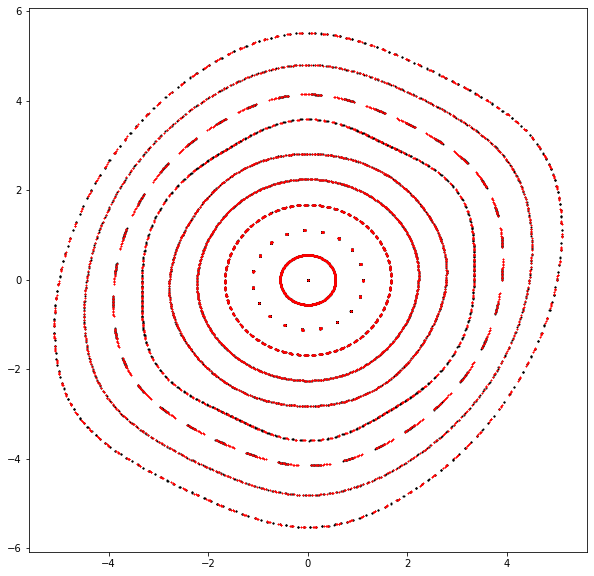

In [6]:
# Compare phase space trajectories
# Note, change order to observe convergence

plt.figure(figsize=(10, 10))

# Direct tracking

x = torch.linspace(0.0, 5.0, 10, dtype=dtype, device=device)
x = torch.stack([x, *3*[torch.zeros_like(x)]]).T

count = 512
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: ring(x))(x)

table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table

for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)

# Table tracking
# Note, table representation is not symplectic
    
x = torch.linspace(0.0, 5.0, 10, dtype=dtype, device=device)
x = torch.stack([x, *3*[torch.zeros_like(x)]]).T

count = 512
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: evaluate(t, [x]))(x)

table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table

for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='red', marker='x', s=1)
    
plt.show()

# Example-06: Fixed point

In [1]:
# In this example fixed points are computed for a simple symplectic nonlinear transformation
# Fixed point are computed with Newton root search

In [2]:
# Import

import numpy
import torch

from ndtorch.pfp import fixed_point
from ndtorch.pfp import clean_point
from ndtorch.pfp import chain_point
from ndtorch.pfp import matrix

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set forward & inverse mappings

mu = 2.0*numpy.pi*torch.tensor(1/3 - 0.01, dtype=dtype)
kq, ks, ko = torch.tensor([0.0, 0.25, -0.25], dtype=dtype)

def forward(x):
    q, p = x
    q, p = q*mu.cos() + p*mu.sin(), p*mu.cos() - q*mu.sin()
    q, p = q, p + (kq*q + ks*q**2 + ko*q**3)
    return torch.stack([q, p])

def inverse(x):
    q, p = x
    q, p = q, p - (kq*q + ks*q**2 + ko*q**3)
    q, p = q*mu.cos() - p*mu.sin(), p*mu.cos() + q*mu.sin()
    return torch.stack([q, p])

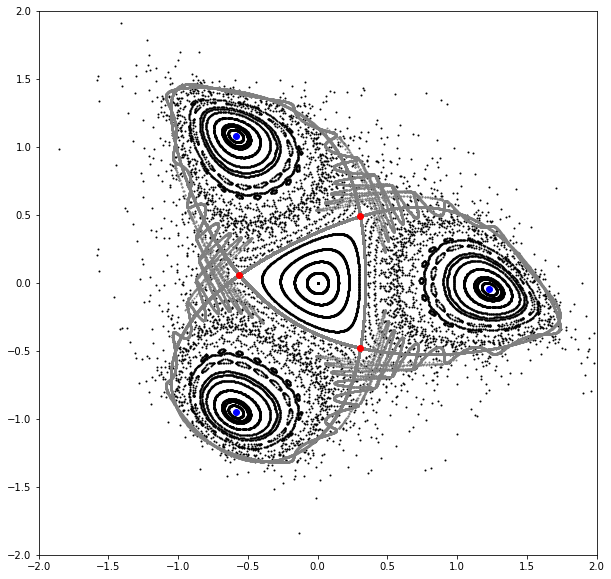

In [5]:
# Compute period three fixed points

# Set fixed point period

period = 3

# Set tolerance epsilon

epsilon = 1.0E-12

# Set random initial points

points = 4.0*torch.rand((128, 2), dtype=dtype, device=device) - 2.0

# Perform 512 root search iterations for each initial point

points = torch.func.vmap(lambda point: fixed_point(512, forward, point, power=period))(points)

# Clean points (remove nans, duplicates, points from the same chain)

points = clean_point(period, forward, points, epsilon=epsilon)

# Generate fixed point chains

chains = torch.func.vmap(lambda point: chain_point(period, forward, point))(points)

# Classify fixed point chains (elliptic vs hyperbolic)
# Generate initials for hyperbolic fixed points using corresponding eigenvectors

kinds = []
for chain in chains:
    point, *_ = chain
    values, vectors = torch.linalg.eig(matrix(period, forward, point))
    kind = all(values.log().real < epsilon)
    kinds.append(kind)
    if not kind:
        lines = [point + vector*torch.linspace(-epsilon, +epsilon, 1024, dtype=dtype).reshape(-1, 1) for vector in vectors.real.T]
        lines = torch.stack(lines)
        
# Plot phase space

x = torch.linspace(0.0, 1.5, 21, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: forward(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Plot (approximated) stable and unstable  manifolds of hyperbolic fixed points

count = 310

for line in lines:
    
    x = torch.clone(line)
    table = []
    for _ in range(count):
        table.append(x)
        x = torch.func.vmap(lambda x: forward(x))(x)
    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='gray', marker='o', s=1)
        
    x = torch.clone(line)
    table = []
    for _ in range(count):
        table.append(x)
        x = torch.func.vmap(lambda x: inverse(x))(x)
    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='gray', marker='o', s=1)
        
# Plot chains

for chain, kind in zip(chains, kinds):
    plt.scatter(*chain.T, color = {True:'blue', False:'red'}[kind], marker='o')

tensor([0., 0.], dtype=torch.float64)
tensor([-1.110223024625e-16,  0.000000000000e+00], dtype=torch.float64)


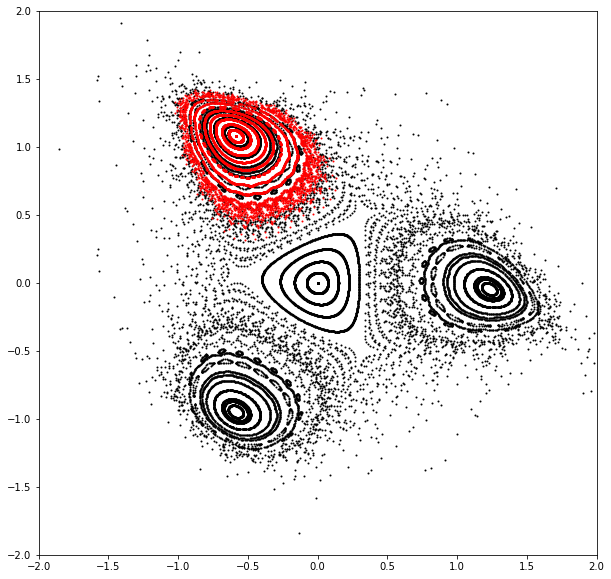

In [6]:
# Set mapping around elliptic fixed point

point, *_ = chains[kinds].squeeze()

def mapping(x):
    x = x + point
    for _ in range(period):
        x = forward(x)
    x = x - point
    return x

# Test mapping

x = torch.zeros_like(point)
print(x)
print(mapping(x))

# Plot phase space

x = torch.linspace(0.0, 1.5, 21, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: forward(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
x = torch.linspace(0.0, 0.5, 11, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: mapping(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table + point.reshape(2, 1, 1)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='red', marker='o', s=1)

# Example-07: Parametric fixed point

In [1]:
# Given a mapping depending on a set of knobs (parameters), parametric fixed points can be computed (position of a fixed point as function of parameters)
# Parametric fixed points can be used to construct responce matrices, e.g. closed orbit responce
# In this case only first order derivatives of the fixed point(s) with respect to parameters are computed
# Or higher order expansions can be computed
# In this example parametric fixed points of a symplectic mapping are computed

In [2]:
# Import

import numpy
import torch

from ndtorch.util import flatten
from ndtorch.evaluate import evaluate
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import clean_point
from ndtorch.pfp import chain_point
from ndtorch.pfp import matrix
from ndtorch.pfp import parametric_fixed_point

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set mapping

def mapping(x, k):
    q, p = x
    a, b = k
    q, p = q*mu.cos() + p*mu.sin(), p*mu.cos() - q*mu.sin()
    return torch.stack([q, p + a*q**2 + b*q**3])

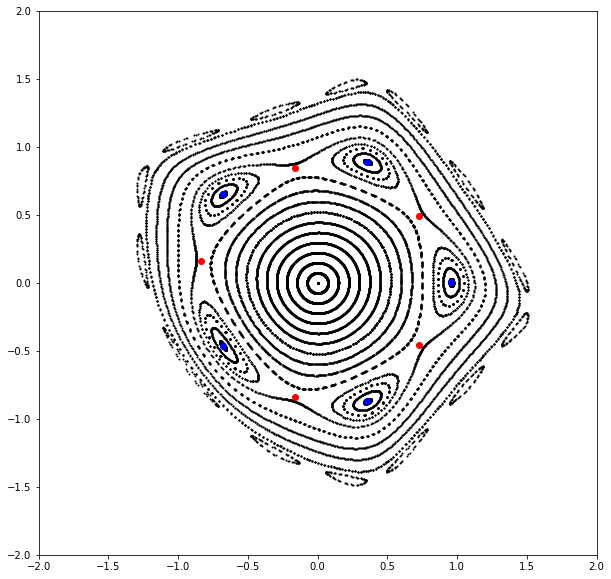

In [5]:
# Compute dynamical fixed points
# Note, fixed point might fail due to escape to large values

# Set parameters

mu = 2.0*numpy.pi*torch.tensor(1/5 - 0.01, dtype=dtype, device=device)
k = torch.tensor([0.25, -0.25], dtype=dtype, device=device)

# Compute and plot phase space trajectories

x = torch.linspace(0.0, 1.5, 21, dtype=dtype)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []
for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: mapping(x, k))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Set tolerance epsilon
    
epsilon = 1.0E-12

# Compute chains
    
period = 5
points = torch.rand((32, 2), dtype=dtype, device=device)
points = torch.func.vmap(lambda point: fixed_point(16, mapping, point, k, power=period))(points)
points = clean_point(period, mapping, points, k, epsilon=epsilon)
chains = torch.func.vmap(lambda point: chain_point(period, mapping, point, k))(points)

# Plot chains

for chain in chains:
    point, *_ = chain
    value, vector = torch.linalg.eig(matrix(period, mapping, point, k))
    color = 'blue' if all(value.log().real < epsilon) else 'red'
    plt.scatter(*chain.T, color=color, marker='o')    
    if color == 'blue':
        ep, *_ = chain
    else:
        hp, *_ = chain
        
plt.show()

In [6]:
# Compute hyperbolic fixed point for a set of knobs

dks = torch.stack(2*[torch.linspace(0.0, 0.01, 101, dtype=dtype, device=device)]).T

fps = [hp]
for dk in dks:
    *_, initial = fps
    fps.append(fixed_point(16, mapping, initial, k + dk, power=period))
    
fps = torch.stack(fps)

In [7]:
# Compute parametric fixed point

# Set computation order
# Note, change order to observe convergence

order = 4
pfp = parametric_fixed_point((order, ), hp, [k], mapping, power=period)

# Set period mapping and check fixed point propagation

def function(x, k):
    for _ in range(period):
        x = mapping(x, k)
    return x

out = propagate((2, 2), (0, order), pfp, [k], function)
for x, y in zip(flatten(pfp, target=list), flatten(out, target=list)):
    print(torch.allclose(x, y))

True
True
True
True
True


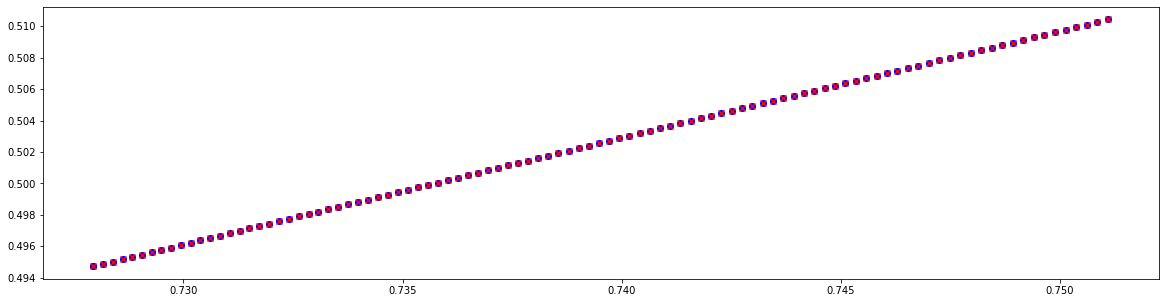

In [8]:
# Plot parametric fixed point position for a given set of knobs

out = torch.func.vmap(lambda dk: evaluate(pfp, [hp, dk]))(dks)

plt.figure(figsize=(20, 5))
plt.scatter(*fps.T.cpu().numpy(), color='blue', marker='o')
plt.scatter(*out.T.cpu().numpy(), color='red', marker='x')
plt.show()

# Example-08: Fixed point manipulation (collision)

In [1]:
# In this example the distance between a pair of hyperbolic and elliptic fixed points is minimized
# First, using a set of initial guesses within a region, a pair is obtained
# For a given pair, first order parametric dependence of fixed point positions is computed
# Gradient of the distance function between the points is computed (GD minimization)

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import clean_point
from ndtorch.pfp import chain_point
from ndtorch.pfp import matrix
from ndtorch.pfp import parametric_fixed_point

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set mapping

limit = 8
phase = 2.0*numpy.pi*(1/4 + 0.005)
phase = torch.tensor(phase/(limit + 1), dtype=dtype, device=device)

def mapping(state, knobs):
    q, p = state
    for index in range(limit):
        q, p = q*phase.cos() + p*phase.sin(), p*phase.cos() - q*phase.sin()
        q, p = q, p + knobs[index]*q**2
    q, p = q*phase.cos() + p*phase.sin(), p*phase.cos() - q*phase.sin()
    q, p = q, p + q**2
    return torch.stack([q, p])

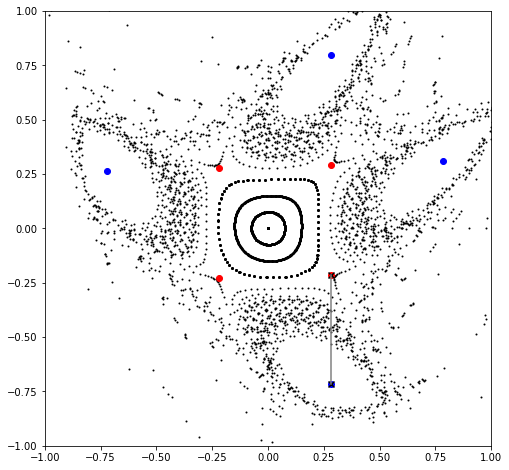

In [5]:
# Locate fixed points and select a pair

# Set initial knobs

knobs = torch.tensor(limit*[0.0], dtype=dtype, device=device)

# Compute and plot phase space trajectories

state = torch.linspace(0.0, 1.5, 21, dtype=dtype)
state = torch.stack([state, torch.zeros_like(state)]).T

count = 1024
table = []
for _ in range(count):
    table.append(state)
    state = torch.func.vmap(lambda state: mapping(state, knobs))(state)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(8, 8))
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Set tolerance epsilon
    
epsilon = 1.0E-12

# Compute chains

period = 4
points = 4.0*torch.rand((512, 2), dtype=dtype, device=device) - 2.0
points = torch.func.vmap(lambda point: fixed_point(64, mapping, point, knobs, power=period))(points)
points = clean_point(period, mapping, points, knobs, epsilon=epsilon)
chains = torch.func.vmap(lambda point: chain_point(period, mapping, point, knobs))(points)

# Plot chains

for chain in chains:
    point, *_ = chain
    value, vector = torch.linalg.eig(matrix(period, mapping, point, knobs))
    color = 'blue' if all(value.log().real < epsilon) else 'red'
    plt.scatter(*chain.T, color=color, marker='o')    
    if color == 'blue':
        ep, *_ = chain
    else:
        hp, *_ = chain
        
ep_chain, *_ = [chain for chain in chains if ep in chain]
hp_chain, *_ = [chain for chain in chains if hp in chain]

ep, *_ = ep_chain
hp, *_ = hp_chain[(ep - hp_chain).norm(dim=-1) == (ep - hp_chain).norm(dim=-1).min()]

plt.scatter(*ep.cpu().numpy(), color='black', marker='x')
plt.scatter(*hp.cpu().numpy(), color='black', marker='x')
plt.plot(*torch.stack([ep, hp]).T.cpu().numpy(), color='gray')

plt.show()

In [6]:
# Compute first order parametric fixed points

order = 1

php = parametric_fixed_point((order, ), hp, [knobs], mapping, power=period)
pep = parametric_fixed_point((order, ), ep, [knobs], mapping, power=period)

In [7]:
# Set objective function

def objective(knobs, php, pep):
    dhp = evaluate(php, [torch.zeros_like(knobs), knobs])
    dep = evaluate(pep, [torch.zeros_like(knobs), knobs])
    return (dep - dhp).norm()

In [8]:
# Set learning rate and update knobs

lr = 0.0025
gradient = derivative(1, objective, knobs, php, pep, intermediate=False)
knobs -= lr*gradient

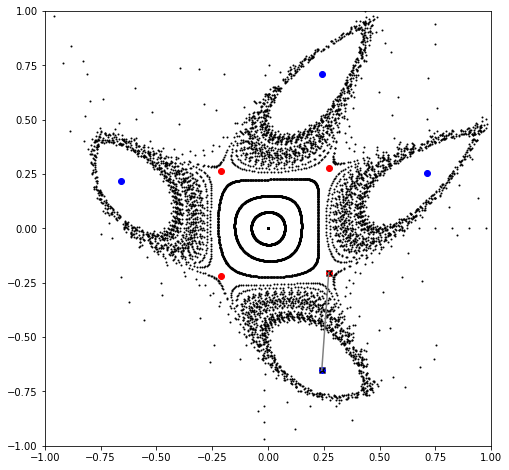

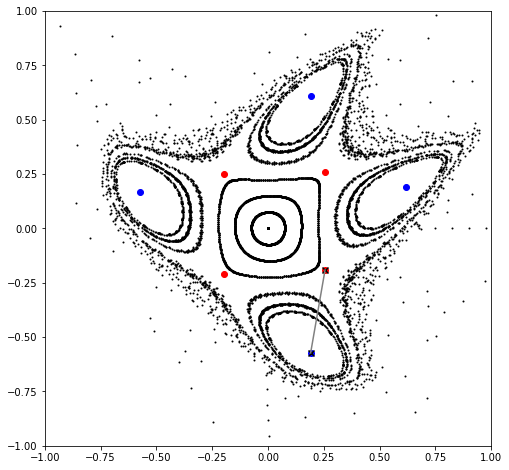

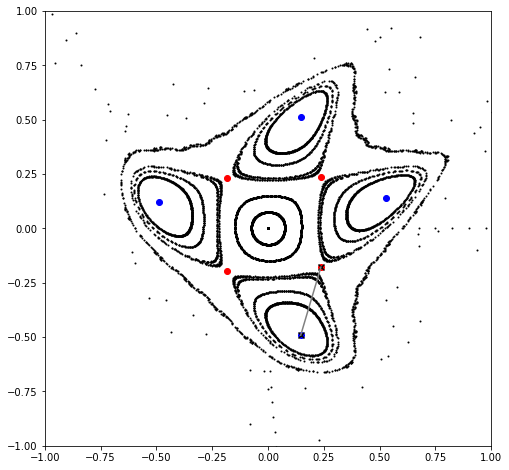

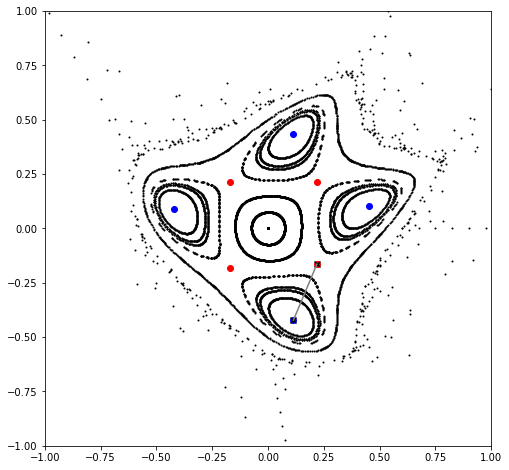

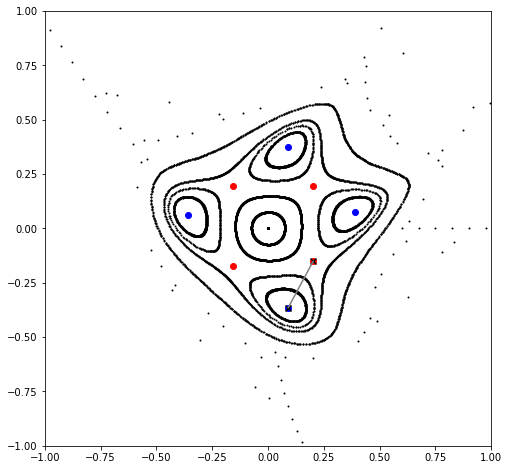

In [9]:
# Iterate

# Set number of iterations

nitr = 5

# Loop

for intr in range(nitr):
    
    # Compute and plot phase space trajectories

    state = torch.linspace(0.0, 1.5, 21, dtype=dtype)
    state = torch.stack([state, torch.zeros_like(state)]).T

    table = []
    for _ in range(count):
        table.append(state)
        state = torch.func.vmap(lambda state: mapping(state, knobs))(state)

    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table

    plt.figure(figsize=(8, 8))
    plt.xlim(-1., 1.)
    plt.ylim(-1., 1.)
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='black', marker='o', s=1)

    # Find fixed points near previous values

    points = torch.stack([hp, ep])
    points = torch.func.vmap(lambda point: fixed_point(64, mapping, point, knobs, power=period))(points)
    points = clean_point(period, mapping, points, knobs, epsilon=epsilon)
    chains = torch.func.vmap(lambda point: chain_point(period, mapping, point, knobs))(points)

    # Plot chains and selected pair

    for chain in chains:
        point, *_ = chain
        value, vector = torch.linalg.eig(matrix(period, mapping, point, knobs))
        color = 'blue' if all(value.log().real < epsilon) else 'red'
        plt.scatter(*chain.T, color=color, marker='o')    
        if color == 'blue':
            ep, *_ = chain
        else:
            hp, *_ = chain

    ep_chain, *_ = [chain for chain in chains if ep in chain]
    hp_chain, *_ = [chain for chain in chains if hp in chain]

    ep, *_ = ep_chain
    hp, *_ = hp_chain[(ep - hp_chain).norm(dim=-1) == (ep - hp_chain).norm(dim=-1).min()]

    plt.scatter(*ep.cpu().numpy(), color='black', marker='x')
    plt.scatter(*hp.cpu().numpy(), color='black', marker='x')
    plt.plot(*torch.stack([ep, hp]).T.cpu().numpy(), color='gray')

    plt.show()

    # Recompute parametric fixed points
    # Note,  not strictly necessary to do at each iteration

    php = parametric_fixed_point((order, ), hp, [knobs], mapping, power=period)
    pep = parametric_fixed_point((order, ), ep, [knobs], mapping, power=period)

    # Update

    lr *= 2.0
    gradient = derivative(1, objective, knobs, php, pep, intermediate=False)
    knobs -= lr*gradient

# Example-09: Fixed point manipulation (change point type)

In [1]:
# In this example real parts of the eigenvalues of a hyperbolic fixed point are minimized
# First, using a set of initial guesses within a region, a hyperbolic point is located
# Parametric fixed point is computed and propagated
# Propagated table is used as a surrogate model to generate differentible objective

In [2]:
# Import

import numpy
import torch

from ndtorch.util import nest
from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import clean_point
from ndtorch.pfp import chain_point
from ndtorch.pfp import matrix
from ndtorch.pfp import parametric_fixed_point

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set mapping

limit = 8
phase = 2.0*numpy.pi*(1/4 + 0.005)
phase = torch.tensor(phase/(limit + 1), dtype=dtype, device=device)

def mapping(state, knobs):
    q, p = state
    for index in range(limit):
        q, p = q*phase.cos() + p*phase.sin(), p*phase.cos() - q*phase.sin()
        q, p = q, p + knobs[index]*q**2
    q, p = q*phase.cos() + p*phase.sin(), p*phase.cos() - q*phase.sin()
    q, p = q, p + q**2
    return torch.stack([q, p])

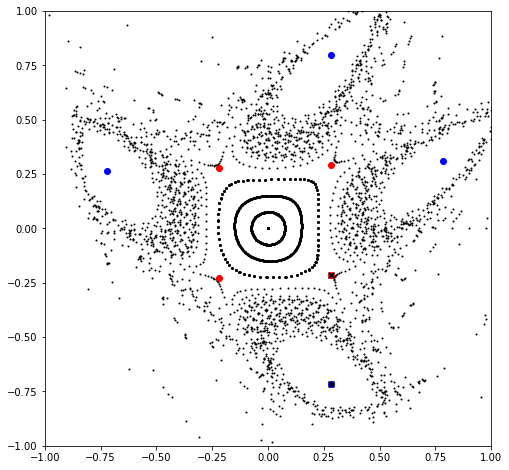

In [5]:
# Locate fixed points and select a pair

# Set initial knobs

knobs = torch.tensor(limit*[0.0], dtype=dtype, device=device)

# Compute and plot phase space trajectories

state = torch.linspace(0.0, 1.5, 21, dtype=dtype)
state = torch.stack([state, torch.zeros_like(state)]).T

count = 1024
table = []
for _ in range(count):
    table.append(state)
    state = torch.func.vmap(lambda state: mapping(state, knobs))(state)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(8, 8))
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Set tolerance epsilon
    
epsilon = 1.0E-12

# Compute chains

period = 4
points = 4.0*torch.rand((512, 2), dtype=dtype, device=device) - 2.0
points = torch.func.vmap(lambda point: fixed_point(64, mapping, point, knobs, power=period))(points)
points = clean_point(period, mapping, points, knobs, epsilon=epsilon)
chains = torch.func.vmap(lambda point: chain_point(period, mapping, point, knobs))(points)

# Plot chains

for chain in chains:
    point, *_ = chain
    value, vector = torch.linalg.eig(matrix(period, mapping, point, knobs))
    color = 'blue' if all(value.log().real < epsilon) else 'red'
    plt.scatter(*chain.T, color=color, marker='o')    
    if color == 'blue':
        ep, *_ = chain
    else:
        hp, *_ = chain
        
ep_chain, *_ = [chain for chain in chains if ep in chain]
hp_chain, *_ = [chain for chain in chains if hp in chain]

ep, *_ = ep_chain
hp, *_ = hp_chain[(ep - hp_chain).norm(dim=-1) == (ep - hp_chain).norm(dim=-1).min()]

plt.scatter(*ep.cpu().numpy(), color='black', marker='x')
plt.scatter(*hp.cpu().numpy(), color='black', marker='x')

plt.show()

In [6]:
# Matrix around (dynamical) fixed points
# Note, eigenvalues of a hyperbolic fixed point are not on the unit circle

em = matrix(period, mapping, ep, knobs)
print(em)
print(torch.linalg.eigvals(em).log().real)
print()

hm = matrix(period, mapping, hp, knobs)
print(hm)
print(torch.linalg.eigvals(hm).log().real)
print()

tensor([[2.739351528140e-01, -1.149307994931e+00],
        [5.971467208895e-01, 1.145141455240e+00]], dtype=torch.float64)
tensor([-1.784726318725e-15, -1.784726318725e-15], dtype=torch.float64)

tensor([[1.251182357765e+00, 1.288812994113e-01],
        [1.428760927086e-01, 8.139613303868e-01]], dtype=torch.float64)
tensor([2.545448611841e-01, -2.545448611841e-01], dtype=torch.float64)



In [7]:
# Compute first order parametric fixed points

order = 1

php = parametric_fixed_point((order, ), hp, [knobs], mapping, power=period)
pep = parametric_fixed_point((order, ), ep, [knobs], mapping, power=period)

In [8]:
# Propagate parametric identity table
# Note, propagated table can be used as a surrogate model around (parametric) fixed point
# Here it is used to compute parametric matrix around fixed point and its egenvalues

t = identity((1, 1), [hp, knobs], parametric=php)
t = propagate((2, limit), (1, 1), t, [knobs], nest(period, mapping, knobs))

In [9]:
# Set objective function

def objective(knobs):
    hm = derivative(1, lambda x, k: evaluate(t, [x, k]), hp, knobs, intermediate=False)
    return torch.linalg.eigvals(hm).log().real.abs().sum()

In [10]:
# Initial objective value

print(objective(knobs))

tensor(5.090897223682e-01, dtype=torch.float64)


In [11]:
# Objective gradient

print(derivative(1, objective, knobs, intermediate=False))

tensor([-1.974190541982e-01, -4.137846718749e-01, -5.970747283789e-01, -7.018818743275e-01,
        -7.018818743275e-01, -5.970747283789e-01, -4.137846718749e-01, -1.974190541982e-01],
       dtype=torch.float64)


In [12]:
# Set learning rate and update knobs

lr = 0.01
gradient = derivative(1, objective, knobs, intermediate=False)
knobs -= lr*gradient

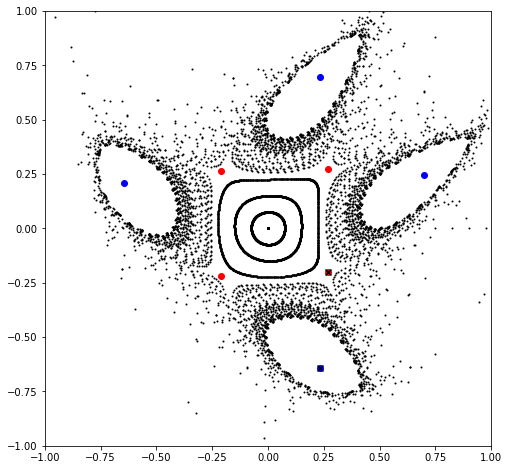

0.4875424149522949


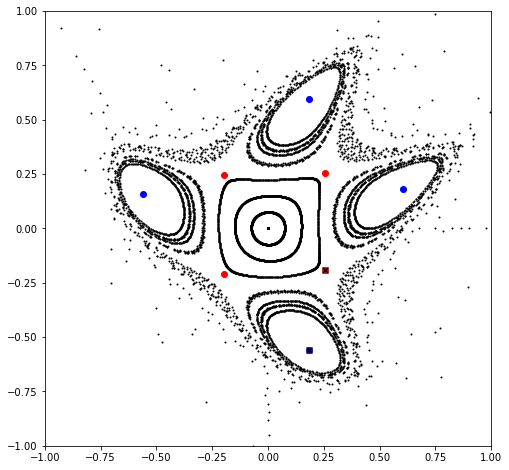

0.44253915640171704


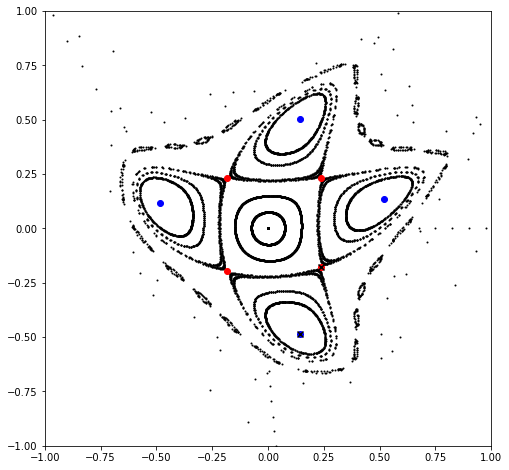

0.3947019262885917


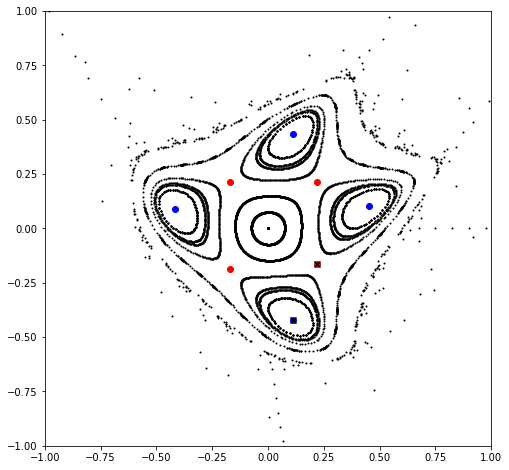

0.34869831355705994


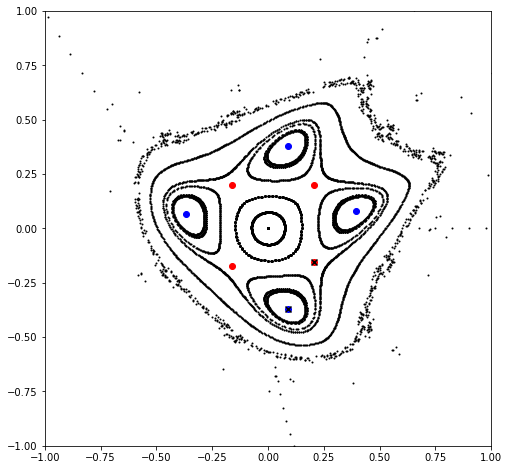

0.3054166976781556


In [13]:
# Iterate

# Set number of iterations

nitr = 5

# Loop

for intr in range(nitr):

    state = torch.linspace(0.0, 1.5, 21, dtype=dtype)
    state = torch.stack([state, torch.zeros_like(state)]).T

    count = 1024
    table = []
    for _ in range(count):
        table.append(state)
        state = torch.func.vmap(lambda state: mapping(state, knobs))(state)

    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table

    plt.figure(figsize=(8, 8))
    plt.xlim(-1., 1.)
    plt.ylim(-1., 1.)
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='black', marker='o', s=1)

    # Set tolerance epsilon

    epsilon = 1.0E-12

    # Compute chains

    period = 4
    points = torch.stack([hp, ep])
    points = torch.func.vmap(lambda point: fixed_point(64, mapping, point, knobs, power=period))(points)
    points = clean_point(period, mapping, points, knobs, epsilon=epsilon)
    chains = torch.func.vmap(lambda point: chain_point(period, mapping, point, knobs))(points)

    # Plot chains

    for chain in chains:
        point, *_ = chain
        value, vector = torch.linalg.eig(matrix(period, mapping, point, knobs))
        color = 'blue' if all(value.log().real < epsilon) else 'red'
        plt.scatter(*chain.T, color=color, marker='o')    
        if color == 'blue':
            ep, *_ = chain
        else:
            hp, *_ = chain

    ep_chain, *_ = [chain for chain in chains if ep in chain]
    hp_chain, *_ = [chain for chain in chains if hp in chain]

    ep, *_ = ep_chain
    hp, *_ = hp_chain[(ep - hp_chain).norm(dim=-1) == (ep - hp_chain).norm(dim=-1).min()]

    plt.scatter(*ep.cpu().numpy(), color='black', marker='x')
    plt.scatter(*hp.cpu().numpy(), color='black', marker='x')

    plt.show()
    print(objective(knobs).item())
    
    # Compute parametric fixed points

    php = parametric_fixed_point((order, ), hp, [knobs], mapping, power=period)
    pep = parametric_fixed_point((order, ), ep, [knobs], mapping, power=period)
    
    # Propagate parametric fixed points

    t = identity((1, 1), [hp, knobs], parametric=php)
    t = propagate((2, limit), (1, 1), t, [knobs], nest(period, mapping, knobs))
    
    # Update

    lr += 0.005
    gradient = derivative(1, objective, knobs, intermediate=False)
    knobs = knobs - lr*gradient

# Example-10: Alignment indices chaos indicators

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative

torch.set_printoptions(precision=8, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set fixed parameters

a1, b1 = 0, 1
a2, b2 = 0, 1

f1 = torch.tensor(2.0*numpy.pi*0.38, dtype=dtype, device=device)
f2 = torch.tensor(2.0*numpy.pi*0.41, dtype=dtype, device=device)

cf1, sf1 = f1.cos(), f1.sin()
cf2, sf2 = f2.cos(), f2.sin()

In [4]:
# Set 4D symplectic mapping

def mapping(x):
    q1, p1, q2, p2 = x
    return torch.stack([
        b1*(p1 + (q1**2 - q2**2))*sf1 + q1*(cf1 + a1*sf1),
        -((q1*(1 + a1**2)*sf1)/b1) + (p1 + (q1**2 - q2**2))*(cf1 - a1*sf1),
        q2*cf2 + (p2*b2 + q2*(a2 - 2*q1*b2))*sf2,
        -((q2*(1 + a2**2)*sf2)/b2) + (p2 - 2*q1*q2)*(cf2 - a2*sf2)
    ])

In [5]:
# Set 4D symplectic mapping with tangent dynamics

def tangent(x, vs):
    x, m = derivative(1, mapping, x)
    vs = torch.func.vmap(lambda v: m @ v)(vs)
    return x, vs/vs.norm(dim=-1, keepdim=True)

In [6]:
# Set generalized alignment indices computation

# Note, if number if vectors is equal to two, the index tends towards zero for regular orbits
# And tends towards a constant value for chaotic motion
# If the number of vectors is greater than two, index tends towards zero for all cases
# But for chaotic orbits, zero is reached (exponentialy) faster

def gali(vs, threshold=1.0E-12):
    return (threshold + torch.linalg.svdvals(vs).prod()).log10()

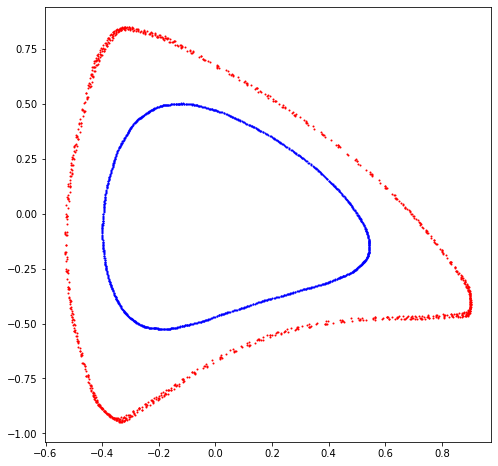

In [7]:
# First, consider two initial conditions (regular and chaotic)

count = 1024

plt.figure(figsize=(8, 8))

x = torch.tensor([0.50000, 0.0, 0.05, 0.0], dtype=dtype)
orbit = []
for _ in range(count):
    x = mapping(x)
    orbit.append(x)
q, p, *_ = torch.stack(orbit).T
plt.scatter(q, p, s =1, color='blue')

x = torch.tensor([0.68925, 0.0, 0.10, 0.0], dtype=dtype)
orbit = []
for _ in range(count):
    x = mapping(x)
    orbit.append(x)
q, p, *_ = torch.stack(orbit).T
plt.scatter(q, p, s =1, color='red')

plt.show()

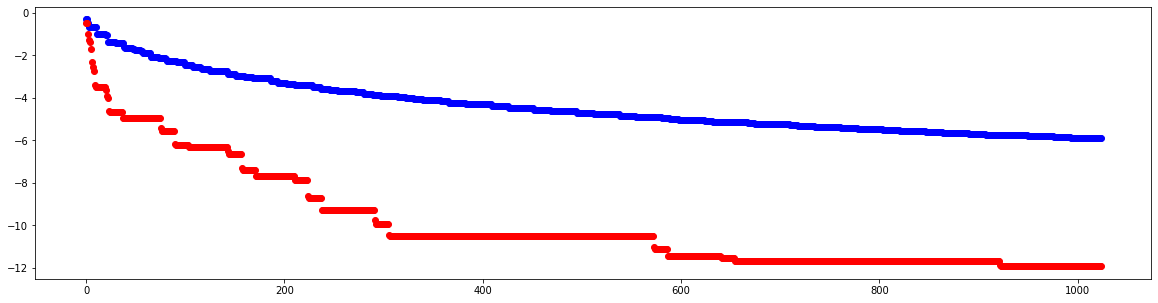

In [8]:
# Compute and plot the last gali index at each iteration
# Note, running minimum is appended at each iteration

plt.figure(figsize=(20, 5))

x = torch.tensor([0.50000, 0.0, 0.05, 0.0], dtype=dtype, device=device)
vs = torch.eye(4, dtype=dtype, device=device)
out = []
for _ in range(count):
    x, vs = tangent(x, vs)
    res = gali(vs)
    out.append(res if not out else min(res, out[-1]))
out = torch.stack(out)
plt.scatter(range(count), out, color='blue', marker='o')
    
x = torch.tensor([0.68925, 0.0, 0.10, 0.0], dtype=dtype, device=device)
vs = torch.eye(4, dtype=dtype, device=device)
out = []
for _ in range(count):
    x, vs = tangent(x, vs)
    res = gali(vs)
    out.append(res if not out else min(res, out[-1]))
out = torch.stack(out)
plt.scatter(range(count), out, color='red', marker='o')
               
plt.show()

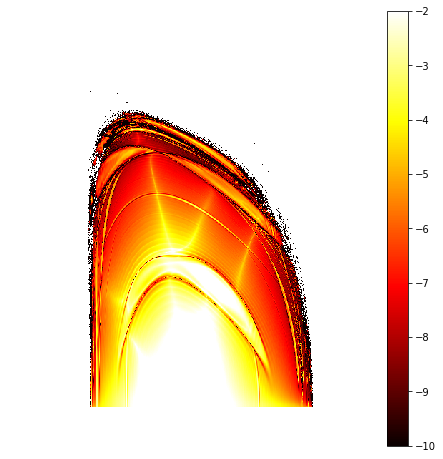

In [9]:
# Compute indicator using all avaliable vectors for a grid of initial conditions

def gali(vs):
    return torch.linalg.svdvals(vs.nan_to_num()).prod()

# Set grid

n1 = 501
n2 = 501

q1 = torch.linspace(-1.0, +1.0, n1, dtype=dtype, device=device)
q2 = torch.linspace(+0.0, +1.0, n2, dtype=dtype, device=device)

qs = torch.stack(torch.meshgrid(q1, q2, indexing='ij')).swapaxes(-1, 0).reshape(n1*n2, -1)
ps = torch.full_like(qs, 1.0E-10)

q1, q2, p1, p2 = torch.hstack([qs, ps]).T

vs = torch.tensor(n1*n2*[torch.eye(4).tolist()], dtype=dtype, device=device)
qs = torch.stack([q1, p1, q2, p2]).T

# Set tast
# Perform 512 iterations, compute min of indicator value over the next 64 iterations

def task(qs, vs, count=512, total=64, level=1.0E-10):
    for _ in range(count):
        qs, vs = tangent(qs, vs)
    out = []
    for _ in range(total):
        qs, vs = tangent(qs, vs)
        out.append(gali(vs))
    return (torch.stack(out).min() + level*torch.sign(qs.norm())).log10()

# Compute and clean data

out = torch.vmap(task)(qs, vs)
out = out.nan_to_num(neginf=0.0)
out[(out >= -2.0)*(out != 0.0)] = -2.0
out[out == 0.0] = torch.nan
out = out.reshape(n1, n2)

# Plot

plt.figure(figsize=(8, 8))
plt.imshow(
    out.cpu().numpy(),
    vmin=-10.0,
    vmax=-2.0,
    aspect='equal',
    origin='lower',
    cmap='hot', 
    interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.show()

# Example-11: Closed orbit (dispersion)

In [1]:
# In this example derivatives of closed orbit with respect to momentum deviation are computed

In [2]:
# Import

import numpy
import torch

from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.series import series
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

torch.set_printoptions(precision=8, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [5]:
# Set transport maps between observation points 
# Note, here observation poins are locations between elements, lattice start and lattice end
# An observable (closed orbit) is computed at observation points

# All maps are expected to have identical signature of differentible parameters
# State and momentum deviation in this example
# But each map can have any number of additional args and kwargs after required parameters

def map_01_02(x, w): return quad(x, w, 0.19, 0.50)
def map_02_03(x, w): return drif(x, w, 0.45)
def map_03_04(x, w): return sext(x, w, 0.00, 0.10)
def map_04_05(x, w): return drif(x, w, 0.45)
def map_05_06(x, w): return bend(x, w, 22.92, 0.015, 0.00, 3.0)
def map_06_07(x, w): return drif(x, w, 0.45)
def map_07_08(x, w): return sext(x, w, 0.00, 0.10)
def map_08_09(x, w): return drif(x, w, 0.45)
def map_09_10(x, w): return quad(x, w, -0.21, 0.50)
def map_10_11(x, w): return quad(x, w, -0.21, 0.50)
def map_11_12(x, w): return drif(x, w, 0.45)
def map_12_13(x, w): return sext(x, w, 0.00, 0.10)
def map_13_14(x, w): return drif(x, w, 0.45)
def map_14_15(x, w): return bend(x, w, 22.92, 0.015, 0.00, 3.0)
def map_15_16(x, w): return drif(x, w, 0.45)
def map_16_17(x, w): return sext(x, w, 0.00, 0.10)
def map_17_18(x, w): return drif(x, w, 0.45)
def map_18_19(x, w): return quad(x, w, 0.19, 0.50)

transport = [
    map_01_02,
    map_02_03,
    map_03_04,
    map_04_05,
    map_05_06,
    map_06_07,
    map_07_08,
    map_08_09,
    map_09_10,
    map_10_11,
    map_11_12,
    map_12_13,
    map_13_14,
    map_14_15,
    map_15_16,
    map_16_17,
    map_17_18,
    map_18_19    
]

# Define one-turn transport

def fodo(x, w):
    for mapping in transport:
        x = mapping(x, w)
    return x

In [6]:
# The first step is to compute dynamical fixed point

# Set initial guess
# Note, in this example zero is a fixed point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Set knobs

w = torch.tensor([0.0], dtype=dtype, device=device)

# Find fixed point

fp = fixed_point(16, fodo, x, w, power=1)

print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Compute parametric closed orbit

pfp = parametric_fixed_point((2, ), fp, [w], fodo)
chop(pfp)

# Print series representation

for key, value in series((4, 1), (0, 2), pfp).items():
    print(f'{key}: {value.cpu().numpy()}')

(0, 0, 0, 0, 0): [0. 0. 0. 0.]
(0, 0, 0, 0, 1): [1.81613351 0.         0.         0.        ]
(0, 0, 0, 0, 2): [0.56855511 0.         0.         0.        ]


In [8]:
# Check convergence

print(evaluate(series((4, 1), (0, 0), pfp), [x, w + 1.0E-3]))
print(evaluate(series((4, 1), (0, 1), pfp), [x, w + 1.0E-3]))
print(evaluate(series((4, 1), (0, 2), pfp), [x, w + 1.0E-3]))
print()

out = fixed_point(16, fodo, x, w + 1.0E-3, power=1)
chop([out])

print(out)
print()

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([1.81613351e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00], dtype=torch.float64)
tensor([1.81670206e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00], dtype=torch.float64)

tensor([  1.81670185e-03,   1.13882757e-19, -5.50391130e-235,   0.00000000e+00], dtype=torch.float64)



In [9]:
# Propagate closed orbit

out = []

jet = identity((0, 1), fp, parametric=pfp)
out.append(jet)

for mapping in transport:
    jet = propagate((4, 1), (0, 2), jet, [w], mapping)
    out.append(jet)

In [10]:
# Check periodicity

print(compare(pfp, jet))

True


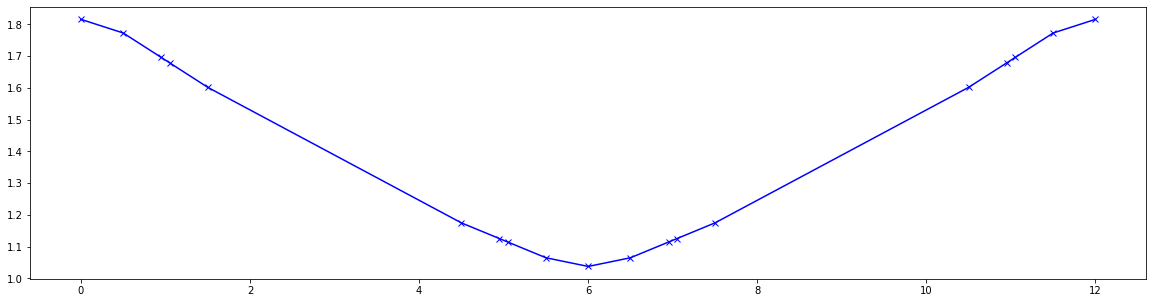

In [11]:
# Plot 1st order dispersion

pos = [0.00, 0.50, 0.95, 1.05, 1.50, 4.50, 4.95, 5.05, 5.50, 6.00, 6.50, 6.95, 7.05, 7.50, 10.50, 10.95, 11.05, 11.50, 12.00]
res = torch.stack([series((4, 1), (0, 2), jet)[(0, 0, 0, 0, 1)][0] for jet in out])

plt.figure(figsize=(20, 5))
plt.plot(pos, res.cpu().numpy(), marker='x', color='blue')
plt.show()

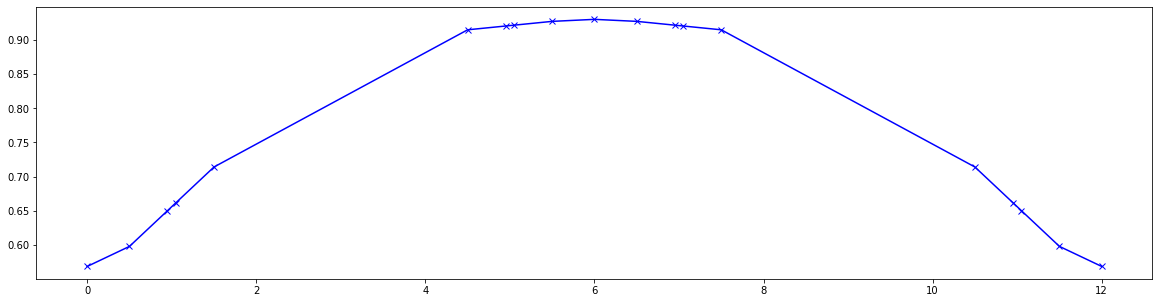

In [12]:
# Plot 2nd order dispersion

pos = [0.00, 0.50, 0.95, 1.05, 1.50, 4.50, 4.95, 5.05, 5.50, 6.00, 6.50, 6.95, 7.05, 7.50, 10.50, 10.95, 11.05, 11.50, 12.00]
res = torch.stack([series((4, 1), (0, 2), jet)[(0, 0, 0, 0, 2)][0] for jet in out])

plt.figure(figsize=(20, 5))
plt.plot(pos, res.cpu().numpy(), marker='x', color='blue')
plt.show()

# Example-12: Closed orbit (quadrupole shift)

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points 

def map_01_02(x, d): 
    dxf, dyf, dxd, dyd = d
    x = quad(x, [0.0], 0.19, 0.50)
    x = slip(x, -dxf, -dyf)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxd, +dyd)
    x = quad(x, [0.0], -0.21, 0.50)
    x = quad(x, [0.0], -0.21, 0.50)
    x = slip(x, -dxd, -dyd)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxf, +dyf)
    x = quad(x, [0.0], 0.19, 0.50)
    return x

transport = [
    map_01_02
]

# Define one-turn transport

def fodo(x, d):
    for mapping in transport:
        x = mapping(x, d)
    return x

In [5]:
# Compute fixed point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
fp = fixed_point(16, fodo, x, d, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute parametric fixed point

pfp = parametric_fixed_point((1, ), fp, [d], fodo)
chop(pfp)
pfp

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[-4.621551e-01, 0.000000e+00, 1.165780e+00, 0.000000e+00],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
          [0.000000e+00, 3.344042e+00, 0.000000e+00, -4.891066e+00],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00]], dtype=torch.float64)]]

In [7]:
# Propagate parametric fixed point

out = propagate((4, 4), (0, 1), pfp, [d], fodo)
chop(out)
out

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[-4.621551e-01, 0.000000e+00, 1.165780e+00, 0.000000e+00],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
          [0.000000e+00, 3.344042e+00, 0.000000e+00, -4.891066e+00],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00]], dtype=torch.float64)]]

In [8]:
# Test single random shift

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = 1.0E-3*torch.randn_like(x)

fp = fixed_point(64, fodo, x, d, power=1, epsilon=1.0E-9)
chop([fp])

print(fp)
print(evaluate(pfp, [x, d]))

tensor([8.482363e-04, 8.125977e-21, 3.353913e-03, 6.171311e-20], dtype=torch.float64)
tensor([8.482363e-04, 0.000000e+00, 3.353913e-03, 0.000000e+00], dtype=torch.float64)


In [9]:
# Estimate center & spread (tracking)

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = 1.0E-3*torch.randn(8192, 4, dtype=dtype, device=device)

fp = torch.func.vmap(lambda d: fixed_point(64, fodo, x, d, power=1))(d)
chop([fp])

print(fp.T.mean(-1))
print(fp.T.std(-1))

tensor([-9.932218e-06,  4.372133e-22, -1.483549e-06,  1.693071e-21], dtype=torch.float64)
tensor([1.253079e-03, 9.554150e-20, 5.881071e-03, 3.289974e-19], dtype=torch.float64)


In [10]:
# Estimate center & spread (surrogate)

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = 1.0E-3*torch.randn(8192, 4, dtype=dtype, device=device)

fp = torch.func.vmap(lambda d: evaluate(pfp, [x, d]))(d)
chop([fp])

print(fp.T.mean(-1))
print(fp.T.std(-1))

tensor([ 3.969686e-06,  0.000000e+00, -2.718688e-05,  0.000000e+00], dtype=torch.float64)
tensor([1.240640e-03, 0.000000e+00, 5.905480e-03, 0.000000e+00], dtype=torch.float64)


In [11]:
# Estimate spread (error propagation)

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
s = derivative(1, lambda d: evaluate(pfp, [x, d]), d, intermediate=False)

print((s @ (1.0E-3*torch.eye(4,  dtype=dtype, device=device))**2 @ s.T).diag().sqrt())

tensor([1.254045e-03, 0.000000e+00, 5.924960e-03, 0.000000e+00], dtype=torch.float64)


# Example-13: Closed orbit (sextupole shift)

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points 

def map_01_02(x, d):
    dxsf1, dysf1, dxsd1, dysd1, dxsf2, dysf2, dxsd2, dysd2 = d
    x = quad(x, [0.0], 0.19, 0.50)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxsf1, +dysf1)
    x = sext(x, [0.0], 0.50, 0.10)
    x = slip(x, -dxsf1, -dysf1)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 3.0)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxsd1, +dysd1)
    x = sext(x, [0.0], -0.50, 0.10)
    x = slip(x, -dxsd1, -dysd1)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21, 0.50)
    x = quad(x, [0.0], -0.21, 0.50)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxsd2, +dysd2)
    x = sext(x, [0.0], -0.50, 0.10)
    x = slip(x, -dxsd2, -dysd2)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 3.0)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxsf2, +dysf2)
    x = sext(x, [0.0], 0.50, 0.10)
    x = slip(x, -dxsf2, -dysf2)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19, 0.50)
    return x

transport = [
    map_01_02
]

# Define one-turn transport

def fodo(x, d):
    for mapping in transport:
        x = mapping(x, d)
    return x

In [5]:
# Compute fixed point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
fp = fixed_point(16, fodo, x, d, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute & check parametric fixed point
# Note, there is no first order contribution from sextupole shifts

pfp = parametric_fixed_point((2, ), fp, [d], fodo)
out = propagate((4, 8), (0, 2), pfp, [d], fodo)
print(compare(pfp, out))

True


In [7]:
# Test for a random shift

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = 1.0E-3*torch.randn(8, dtype=dtype, device=device)

fp = fixed_point(64, fodo, x, d, power=1, epsilon=1.0E-9)

print(fp)
print(evaluate(pfp, [x, d]))

tensor([ 2.446138e-07, -1.144473e-08, -8.221335e-07,  6.156318e-09], dtype=torch.float64)
tensor([ 2.442916e-07, -1.142839e-08, -8.240374e-07,  6.170032e-09], dtype=torch.float64)


In [8]:
# Estimate center & spread (tracking)

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = 1.0E-3*torch.randn(8192, 8, dtype=dtype, device=device)

fp = torch.func.vmap(lambda d: fixed_point(64, fodo, x, d, power=1))(d)
chop([fp])

print(fp.T.mean(-1))
print(fp.T.std(-1))

tensor([-1.018030e-09, -2.975896e-10, -1.314171e-08, -2.126598e-11], dtype=torch.float64)
tensor([6.895581e-07, 3.187716e-08, 1.813973e-06, 2.939394e-08], dtype=torch.float64)


In [9]:
# Estimate center & spread (surrogate)

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
d = 1.0E-3*torch.randn(8192, 8, dtype=dtype, device=device)

fp = torch.func.vmap(lambda d: evaluate(pfp, [x, d]))(d)
chop([fp])

print(fp.T.mean(-1))
print(fp.T.std(-1))

tensor([-4.887936e-09, -1.410492e-10, -3.069499e-09, -4.740614e-10], dtype=torch.float64)
tensor([6.769223e-07, 3.104300e-08, 1.819394e-06, 2.833964e-08], dtype=torch.float64)


# Example-14: Closed orbit (responce matrix & correction)

In [1]:
# In this example orbit responce matrix is computed
# Quadrupole shifts are introduced and responce matrix is used to correct the orbit at observation locations

# Correctors are at sextupole centers
# Observation points are at bend centers

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=25):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [5]:
# Set transport maps between observation points 

def map_01_02(x, c, d): 
    cxsf1, cxsd1, cxsf2, cxsd2, cysf1, cysd1, cysf2, cysd2 = c
    dxf, dyf, dxd, dyd = d
    x = quad(x, [0.0], 0.19, 0.50)
    x = slip(x, -dxf, -dyf)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.05)
    x = kick(x, cxsf1, cysf1)
    x = sext(x, [0.0], 0.00, 0.05)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 1.5)
    return x

def map_02_03(x, c, d):
    cxsf1, cxsd1, cxsf2, cxsd2, cysf1, cysd1, cysf2, cysd2 = c
    dxf, dyf, dxd, dyd = d
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 1.5)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.05)
    x = kick(x, cxsd1, cysd1)
    x = sext(x, [0.0], 0.00, 0.05)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxd, +dyd)
    x = quad(x, [0.0], -0.21, 0.50)
    x = quad(x, [0.0], -0.21, 0.50)
    x = slip(x, -dxd, -dyd)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.05)
    x = kick(x, cxsd2, cysd2)
    x = sext(x, [0.0], 0.00, 0.05)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 1.5)
    return x

def map_03_04(x, c, d):
    cxsf1, cxsd1, cxsf2, cxsd2, cysf1, cysd1, cysf2, cysd2 = c
    dxf, dyf, dxd, dyd = d
    x = bend(x, [0.0], 22.92, 0.015, 0.00, 1.5)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.05)
    x = kick(x, cxsf2, cysf2)
    x = sext(x, [0.0], 0.00, 0.05)
    x = drif(x, [0.0], 0.45)
    x = slip(x, +dxf, +dyf)
    x = quad(x, [0.0], 0.19, 0.50)
    return x

transport = [
    map_01_02,
    map_02_03,
    map_03_04
]

# Define one-turn transport

def fodo(x, c, d):
    for mapping in transport:
        x = mapping(x, c, d)
    return x

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
c = torch.tensor(8*[0.0], dtype=dtype, device=device)
d = torch.tensor(4*[0.0], dtype=dtype, device=device)
print(fodo(x, c, d))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
c = torch.tensor(8*[0.0], dtype=dtype, device=device)
d = torch.tensor(4*[0.0], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, c, d, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Compute parametric fixed point

pfp = parametric_fixed_point((1, ), fp, [c], fodo, d)
chop(pfp)
pfp

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[7.583253e+00, 5.939607e+00, 7.583253e+00, 5.939607e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
          [-4.334732e-01, -9.086786e-02, 4.334732e-01, 9.086786e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.349234e+01, 2.165892e+01, 1.349234e+01, 2.165892e+01],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, -4.019148e-01, -7.725758e-02, 4.019148e-01, 7.725758e-02]],
         dtype=torch.float64)]]

In [8]:
# Propagate parametric fixed point

out = propagate((4, 8), (0, 1), pfp, [c], fodo, d)
chop(out)
out

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[7.583253e+00, 5.939607e+00, 7.583253e+00, 5.939607e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
          [-4.334732e-01, -9.086786e-02, 4.334732e-01, 9.086786e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.349234e+01, 2.165892e+01, 1.349234e+01, 2.165892e+01],
          [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, -4.019148e-01, -7.725758e-02, 4.019148e-01, 7.725758e-02]],
         dtype=torch.float64)]]

In [9]:
# Orbit derivatives at observation locations

bag = []

pfp = propagate((4, 8), (0, 1), pfp, [c], map_01_02, d)
chop(pfp)
bag.append(pfp)

pfp = propagate((4, 8), (0, 1), pfp, [c], map_02_03, d)
chop(pfp)
bag.append(pfp)

In [10]:
# Compute responce matrix

def orbit(c, pfp):
    qx, _, qy, _ = evaluate(pfp, [x, c]) 
    return torch.stack([qx, qy])

pfp1, pfp2 = bag

rx1, ry1 = derivative(1, orbit, c, pfp1, intermediate=False)
rx2, ry2 = derivative(1, orbit, c, pfp2, intermediate=False)

rm = torch.stack([rx1, rx2, ry1, ry2])
print(rm)

tensor([[6.221115e+00, 4.042085e+00, 6.753998e+00, 4.569069e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
        [6.753998e+00, 4.569069e+00, 6.221115e+00, 4.042085e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.808222e+01, 2.754871e+01, 1.855563e+01, 2.802741e+01],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.855563e+01, 2.802741e+01, 1.808222e+01, 2.754871e+01]],
       dtype=torch.float64)


In [11]:
# Generate perturbed orbit

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
c = torch.tensor(8*[0.0], dtype=dtype, device=device)
d = torch.tensor([0.001, 0.001, -0.001, 0.001], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, c, d, power=1)

qx1, _, qy1, _ = map_01_02(fp, c, d)
qx2, _, qy2, _ = map_02_03(map_01_02(fp, c, d), c, d)

o = torch.stack([qx1, qx2, qy1, qy2])
chop([o])
print(o)

tensor([-2.161122e-03, -2.161122e-03, -3.001730e-03, -3.001730e-03], dtype=torch.float64)


In [12]:
# Correct orbit

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
c = - (torch.linalg.pinv(rm) @ o)
d = torch.tensor([0.001, 0.001, -0.001, 0.001], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, c, d, power=1)

qx1, _, qy1, _ = map_01_02(fp, c, d)
qx2, _, qy2, _ = map_02_03(map_01_02(fp, c, d), c, d)

o = torch.stack([qx1, qx2, qy1, qy2])
chop([o])
print(o)

tensor([-1.070014e-18,  3.763685e-18, -1.733072e-17, -1.661201e-17], dtype=torch.float64)


# Example-15: Tune (chromaticity)

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

from twiss.twiss import twiss

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points 

def map_01_02(x, w, k):
    ksf, ksd, ksb = k
    x = quad(x, w, 0.19, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, ksf, 0.10)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, ksb, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, ksd, 0.10)
    x = drif(x, w, 0.45)
    x = quad(x, w, -0.21, 0.50)
    x = quad(x, w, -0.21, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, ksd, 0.10)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, ksb, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, ksf, 0.10)
    x = drif(x, w, 0.45)
    x = quad(x, w, 0.19, 0.50)
    return x

transport = [
    map_01_02
]

# Define one-turn transport

def fodo(x, d, k):
    for mapping in transport:
        x = mapping(x, d, k)
    return x

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
w = torch.tensor(1*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

print(fodo(x, w, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Compute fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
w = torch.tensor(1*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, w, k, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute parametric fixed point

pfp = parametric_fixed_point((1, 1), fp, [w, k], fodo)
chop(pfp)
pfp

[[[tensor([0., 0., 0., 0.], dtype=torch.float64),
   tensor([[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]], dtype=torch.float64)],
  [tensor([[1.816134e+00],
           [0.000000e+00],
           [0.000000e+00],
           [0.000000e+00]], dtype=torch.float64),
   tensor([[[0.],
            [0.],
            [0.]],
   
           [[0.],
            [0.],
            [0.]],
   
           [[0.],
            [0.],
            [0.]],
   
           [[0.],
            [0.],
            [0.]]], dtype=torch.float64)]]]

In [7]:
# Propagate parametric fixed point

out = propagate((4, 1, 3), (0, 1, 1), pfp, [w, k], fodo)
chop(out)
out

[[[tensor([0., 0., 0., 0.], dtype=torch.float64),
   tensor([[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]], dtype=torch.float64)],
  [tensor([[1.816134e+00],
           [0.000000e+00],
           [0.000000e+00],
           [0.000000e+00]], dtype=torch.float64),
   tensor([[[0.],
            [0.],
            [0.]],
   
           [[0.],
            [0.],
            [0.]],
   
           [[0.],
            [0.],
            [0.]],
   
           [[0.],
            [0.],
            [0.]]], dtype=torch.float64)]]]

In [8]:
# Propagate parametric identity (surrogate model for linear dynamics)

jet = identity((1, 1, 1), fp, parametric=pfp)
jet = propagate((4, 1, 3), (1, 1, 1), jet, [w, k], fodo)

In [9]:
# Compute tune

def tune(w, k):
    m = derivative(1, lambda x: evaluate(jet, [x, w, k]), fp, intermediate=False)
    t, *_ = twiss(m)
    return t

print(tune(w, k))

tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)


In [10]:
# Compute parametric tune

t = derivative((1, 1), tune, w, k)

print(t)

[[tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64), tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)], [tensor([[-2.343079e-01],
        [-2.416176e-01]], dtype=torch.float64), tensor([[[3.618782e-01],
         [8.705079e-02],
         [5.873074e+00]],

        [[-2.986097e-01],
         [-4.727344e-01],
         [-1.106560e+01]]], dtype=torch.float64)]]


In [11]:
# Check convergence

print(evaluate(t, [w, k]))
print(evaluate(t, [w + 1.0E-3, k]))
print()

print(tune(w + 1.0E-3, k))

tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)
tensor([2.525452e-01, 1.196688e-01], dtype=torch.float64)

tensor([2.525452e-01, 1.196687e-01], dtype=torch.float64)


In [12]:
# Check convergence

print(evaluate(t, [w, k]))
print(evaluate(t, [w + 1.0E-3, k]))
print(evaluate(t, [w + 1.0E-3, k + 1.0E-2]))
print()

print(tune(w + 1.0E-3, k + 1.0E-2))

tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)
tensor([2.525452e-01, 1.196688e-01], dtype=torch.float64)
tensor([2.526084e-01, 1.195504e-01], dtype=torch.float64)

tensor([2.526084e-01, 1.195502e-01], dtype=torch.float64)


In [13]:
# Series representation

for key, value in clean(series((1, 3), (1, 1), t)).items():
    print(f'{key}: {value}')

(0, 0, 0, 0): tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)
(1, 0, 0, 0): tensor([-2.343079e-01, -2.416176e-01], dtype=torch.float64)
(1, 1, 0, 0): tensor([3.618782e-01, -2.986097e-01], dtype=torch.float64)
(1, 0, 1, 0): tensor([8.705079e-02, -4.727344e-01], dtype=torch.float64)
(1, 0, 0, 1): tensor([5.873074e+00, -1.106560e+01], dtype=torch.float64)


In [14]:
# Set chromaticity to zero

A = derivative((1, 1), lambda w, k: evaluate(t, [w, k]), w, k, intermediate=False)
b = derivative(1, lambda w, k: evaluate(t, [w, k]), w, k, intermediate=False).flatten()

print(derivative(1, lambda w: evaluate(t, [w, k]), w, intermediate=False).flatten())
print(derivative(1, lambda w: evaluate(t, [w, - (torch.linalg.pinv(A.squeeze()) @ b)]), w, intermediate=False).flatten())

tensor([-2.343079e-01, -2.416176e-01], dtype=torch.float64)
tensor([-2.914335e-15,  1.165734e-15], dtype=torch.float64)


In [15]:
# Set chromaticity to one

A = derivative((1, 1), lambda w, k: evaluate(t, [w, k]), w, k, intermediate=False)
b = -1.0 + derivative(1, lambda w, k: evaluate(t, [w, k]), w, k, intermediate=False).flatten()

print(derivative(1, lambda w: evaluate(t, [w, k]), w, intermediate=False).flatten())
print(derivative(1, lambda w: evaluate(t, [w, - (torch.linalg.pinv(A.squeeze()) @ b)]), w, intermediate=False).flatten())

tensor([-2.343079e-01, -2.416176e-01], dtype=torch.float64)
tensor([1.000000e+00, 1.000000e+00], dtype=torch.float64)


# Example-16: Tune (responce matrix & correction)

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

from twiss.twiss import twiss

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points 

def map_01_02(x, k):
    kqf, kqd, kqb = k
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.0, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.0, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    return x

transport = [
    map_01_02
]

# Define one-turn transport

def fodo(x, k):
    for mapping in transport:
        x = mapping(x, k)
    return x

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

print(fodo(x, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Compute fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, k, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute parametric fixed point

pfp = parametric_fixed_point((1, ), fp, [k], fodo)
chop(pfp)
pfp

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64)]]

In [7]:
# Propagate parametric fixed point

out = propagate((4, 3), (0, 1), pfp, [k], fodo)
chop(out)
out

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64)]]

In [8]:
# Propagate parametric identity (surrogate model for linear dynamics)

jet = identity((1, 1), fp, parametric=pfp)
jet = propagate((4, 3), (1, 1), jet, [k], fodo)

In [9]:
# Compute tune

def tune(k):
    m = derivative(1, lambda x: evaluate(jet, [x, k]), fp, intermediate=False)
    t, *_ = twiss(m)
    return t

print(tune(k))

tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)


In [10]:
# Compute parametric tune

t = derivative((1, ), tune, k)

In [11]:
# Check convergence

print(evaluate(t, [k]))
print(evaluate(t, [k + torch.tensor([5.0E-3, 5.0E-3, 1.0E-3], dtype=dtype, device=device)]))
print()

print(tune(k + torch.tensor([5.0E-3, 5.0E-3, 1.0E-3], dtype=dtype, device=device)))

tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)
tensor([2.646746e-01, 9.564416e-02], dtype=torch.float64)

tensor([2.646564e-01, 9.339156e-02], dtype=torch.float64)


In [12]:
# Responce matrix

print(derivative(1, lambda k: evaluate(t, [k]), k, intermediate=False))

tensor([[1.217003e+00, 3.230152e-01, 4.195000e+00],
        [-7.757018e-01, -2.437956e+00, -8.197983e+00]], dtype=torch.float64)


In [13]:
# Correct tunes (increase horizontal by 0.01)

A = derivative(1, lambda k: evaluate(t, [k]), k, intermediate=False)
b = -torch.tensor([0.01, 0.0], dtype=dtype, device=device)

print(tune(k))
print(tune(-(torch.linalg.pinv(A) @ b)))
print()

tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)
tensor([2.627666e-01, 1.199040e-01], dtype=torch.float64)



# Example-17: Tune (spread)

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

from twiss.twiss import twiss

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points 

def map_01_02(x, k):
    kqf, kqd, kqb = k
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.0, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.0, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.0, 0.10)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    return x

transport = [
    map_01_02
]

# Define one-turn transport

def fodo(x, k):
    for mapping in transport:
        x = mapping(x, k)
    return x

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

print(fodo(x, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Compute fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, k, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute parametric fixed point

pfp = parametric_fixed_point((2, ), fp, [k], fodo)
chop(pfp)
pfp

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64),
  tensor([[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]], dtype=torch.float64)]]

In [7]:
# Propagate parametric fixed point

out = propagate((4, 3), (0, 2), pfp, [k], fodo)
chop(out)
out

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64),
  tensor([[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]], dtype=torch.float64)]]

In [8]:
# Propagate parametric identity (surrogate model for linear dynamics)

jet = identity((1, 2), fp, parametric=pfp)
jet = propagate((4, 3), (1, 2), jet, [k], fodo)

In [9]:
# Compute tune

def tune(k):
    m = derivative(1, lambda x: evaluate(jet, [x, k]), fp, intermediate=False)
    t, *_ = twiss(m)
    return t

print(tune(k))

tensor([2.527795e-01, 1.199104e-01], dtype=torch.float64)


In [10]:
# Compute tune spread (direct)

sf = 1.0E-3
sd = 1.0E-3
sb = 1.0E-4

def wrapper(k):
    t, *_ = twiss(derivative(1, fodo, x, k, intermediate=False))
    return t

err = torch.tensor([sf, sd, sb])*torch.randn(8192).unsqueeze(1).to(dtype).to(device)
out = torch.func.vmap(wrapper)(err).T

print(out.mean(-1))
print(out.std(-1))
print()

tensor([2.527650e-01, 1.198656e-01], dtype=torch.float64)
tensor([1.958515e-03, 4.040516e-03], dtype=torch.float64)



In [11]:
# Compute parametric tune

t = derivative((1, ), tune, k)

In [12]:
# Compute tune spread (surrogate)

sf = 1.0E-3
sd = 1.0E-3
sb = 1.0E-4

err = torch.tensor([sf, sd, sb])*torch.randn(8192).unsqueeze(1).to(dtype).to(device)
out = torch.func.vmap(lambda k: evaluate(t, [k]))(err).T

print(out.mean(-1))
print(out.std(-1))
print()

tensor([2.528075e-01, 1.198527e-01], dtype=torch.float64)
tensor([1.973939e-03, 4.063140e-03], dtype=torch.float64)



# Example-18: Parametric twiss

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

from twiss.twiss import twiss
from twiss.twiss import propagate as propagate_twiss
from twiss.convert import wolski_to_cs

torch.set_printoptions(precision=3, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points 

def map_01_02(x, k): 
    kqf, kqd, kqb = k
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    return x

def map_02_03(x, k):
    kqf, kqd, kqb = k
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.1)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    return x

def map_03_04(x, k):
    kqf, kqd, kqb = k
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.1)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    return x

transport = [
    map_01_02,
    map_02_03,
    map_03_04
]

# Define one-turn transport

def fodo(x, k):
    for mapping in transport:
        x = mapping(x, k)
    return x

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

print(fodo(x, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Compute fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, k, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute parametric fixed point

pfp = parametric_fixed_point((1, ), fp, [k], fodo)
chop(pfp)
pfp

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64)]]

In [7]:
# Propagate parametric fixed point

out = propagate((4, 3), (0, 1), pfp, [k], fodo)
chop(out)
out

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64)]]

In [8]:
# Propagate parametric identity (surrogate model for linear dynamics)

jet = identity((1, 1), fp, parametric=pfp)
jet = propagate((4, 3), (1, 1), jet, [k], fodo)

In [9]:
# Compute twiss

# Note, exact or jet one-turn transport can be used
# Other maps can be replaced with jets too

def fn(k, fodo):
    
    bxs = []
    bys = []
    
    m = derivative(1, fodo, fp, intermediate=False)
    
    t, _, w = twiss(m)
    _, bx, _, by = wolski_to_cs(w)
    
    for mapping in transport:
        w = propagate_twiss(w, derivative(1, mapping, x, k, intermediate=False))
        _, bx, _, by = wolski_to_cs(w)
        bxs.append(bx)
        bys.append(by)
    
    return torch.stack([*t, *bxs, *bys])

print(fn(k, fodo=lambda x: evaluate(jet, [x, k])))

tensor([2.528e-01, 1.199e-01, 8.703e+00, 8.703e+00, 1.553e+01, 1.678e+01, 1.678e+01, 9.586e+00], dtype=torch.float64)


In [10]:
# Compute parametric derivative using exact map (tune & beta)

d = derivative((1, ), lambda k: fn(k, fodo=lambda x: fodo(x, k)), k)

print(d)

[tensor([2.528e-01, 1.199e-01, 8.703e+00, 8.703e+00, 1.553e+01, 1.678e+01, 1.678e+01, 9.586e+00], dtype=torch.float64), tensor([[ 1.217e+00,  3.230e-01,  4.195e+00],
        [-7.757e-01, -2.438e+00, -8.198e+00],
        [-3.111e+01, -1.531e+01, -1.101e+02],
        [-3.111e+01, -1.531e+01, -1.101e+02],
        [-1.749e+00, -3.120e+01, -1.799e+02],
        [ 1.153e+02,  3.308e+02,  1.106e+03],
        [ 1.153e+02,  3.308e+02,  1.106e+03],
        [ 5.215e+01,  2.146e+02,  6.957e+02]], dtype=torch.float64)]


In [11]:
# Compute parametric derivative using jet map (tune & beta)

d = derivative((1, ), lambda k: fn(k, fodo=lambda x: evaluate(jet, [x, k])), k)

print(d)

[tensor([2.528e-01, 1.199e-01, 8.703e+00, 8.703e+00, 1.553e+01, 1.678e+01, 1.678e+01, 9.586e+00], dtype=torch.float64), tensor([[ 1.217e+00,  3.230e-01,  4.195e+00],
        [-7.757e-01, -2.438e+00, -8.198e+00],
        [-3.111e+01, -1.531e+01, -1.101e+02],
        [-3.111e+01, -1.531e+01, -1.101e+02],
        [-1.749e+00, -3.120e+01, -1.799e+02],
        [ 1.153e+02,  3.308e+02,  1.106e+03],
        [ 1.153e+02,  3.308e+02,  1.106e+03],
        [ 5.215e+01,  2.146e+02,  6.957e+02]], dtype=torch.float64)]


In [12]:
# Check covergence

dk = torch.tensor([1.0E-3, 1.0E-3, 1.0E-4], dtype=dtype, device=device)

values = fn(k, fodo=lambda x: fodo(x, k))
print(' '.join([f'{value:.3f}' for value in values.cpu().tolist()]))

values = evaluate(d, [dk])
print(' '.join([f'{value:.3f}' for value in values.cpu().tolist()]))

values = fn(k + dk, fodo=lambda x: fodo(x, k + dk))
print(' '.join([f'{value:.3f}' for value in values.cpu().tolist()]))

0.253 0.120 8.703 8.703 15.532 16.780 16.780 9.586
0.255 0.116 8.645 8.645 15.481 17.337 17.337 9.922
0.255 0.116 8.646 8.646 15.482 17.366 17.366 9.940


In [13]:
# Responce matrix

m = derivative((1, ), lambda k: fn(k, fodo=lambda x: evaluate(jet, [x, k])), k, intermediate=False)

print(m)

tensor([[ 1.217e+00,  3.230e-01,  4.195e+00],
        [-7.757e-01, -2.438e+00, -8.198e+00],
        [-3.111e+01, -1.531e+01, -1.101e+02],
        [-3.111e+01, -1.531e+01, -1.101e+02],
        [-1.749e+00, -3.120e+01, -1.799e+02],
        [ 1.153e+02,  3.308e+02,  1.106e+03],
        [ 1.153e+02,  3.308e+02,  1.106e+03],
        [ 5.215e+01,  2.146e+02,  6.957e+02]], dtype=torch.float64)


In [14]:
# Correction

# The target values (tunes and beta functions) are associated with model response matrix
# Given measured values, the goal is to alter knobs to get target values

# Set target values

vf = fn(k, fodo=lambda x: fodo(x, k))

# Set initial solution

sol = torch.zeros_like(dk)

# Iterate

for _ in range(4):

    # Compute current values and set difference

    vi = fn(k + dk + sol, fodo=lambda x: evaluate(jet, [x, k + dk + sol]))

    # Set difference

    dv = vf - vi

    # Update solution

    sol += torch.linalg.pinv(m) @ dv

    # Verbose

    print(-dk)
    print(sol)
    print(dv.norm())
    print()
    
    # Continue

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.064e-03, -1.258e-03, -4.094e-05], dtype=torch.float64)
tensor(9.036e-01, dtype=torch.float64)

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.000e-03, -1.000e-03, -9.990e-05], dtype=torch.float64)
tensor(4.251e-02, dtype=torch.float64)

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor(8.589e-05, dtype=torch.float64)

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor(3.559e-10, dtype=torch.float64)



In [15]:
# Note, similar to tune spread example, it is possible to compute twiss spread
# First order computation can be performed using error propagation
# Or higher order jets can be sampled

# Example-19: Parametric phase advance

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

from twiss.twiss import twiss
from twiss.twiss import propagate as propagate_twiss
from twiss.twiss import advance

torch.set_printoptions(precision=3, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=50):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=10):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=50):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points 

def map_01_02(x, k): 
    kqf, kqd, kqb = k
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    return x

def map_02_03(x, k):
    kqf, kqd, kqb = k
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.10)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = quad(x, [0.0], -0.21 + kqd, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.1)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    return x

def map_03_04(x, k):
    kqf, kqd, kqb = k
    x = bend(x, [0.0], 22.92, 0.015 + kqb, 0.00, 1.5)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.00, 0.1)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19 + kqf, 0.50)
    return x

transport = [
    map_01_02,
    map_02_03,
    map_03_04
]

# Define one-turn transport

def fodo(x, k):
    for mapping in transport:
        x = mapping(x, k)
    return x

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

print(fodo(x, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Compute fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

fp = fixed_point(16, fodo, x, k, power=1)
print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute parametric fixed point

pfp = parametric_fixed_point((1, ), fp, [k], fodo)
chop(pfp)
pfp

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64)]]

In [7]:
# Propagate parametric fixed point

out = propagate((4, 3), (0, 1), pfp, [k], fodo)
chop(out)
out

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]], dtype=torch.float64)]]

In [8]:
# Propagate parametric identity (surrogate model for linear dynamics)

jet = identity((1, 1), fp, parametric=pfp)
jet = propagate((4, 3), (1, 1), jet, [k], fodo)

In [9]:
# Compute phase advance

# Note, exact or jet one-turn transport can be used
# Other maps can be replaced with jets too

def fn(k, fodo):
    
    mus = []
    
    m = derivative(1, fodo, fp, intermediate=False)
    
    t, n, _ = twiss(m)
    
    for mapping in transport:
        mu, n = advance(n, derivative(1, mapping, x, k, intermediate=False))
        mus.append(mu)
    
    mus = torch.stack(mus).T

    return torch.stack([*t, *mus.flatten()])

print(fn(k, fodo=lambda x: evaluate(jet, [x, k])))

tensor([2.528e-01, 1.199e-01, 2.521e-01, 1.084e+00, 2.521e-01, 2.468e-01, 2.599e-01, 2.468e-01], dtype=torch.float64)


In [10]:
# Compute parametric derivative using exact map (tune & advance)

d = derivative((1, ), lambda k: fn(k, fodo=lambda x: fodo(x, k)), k)

print(d)

[tensor([2.528e-01, 1.199e-01, 2.521e-01, 1.084e+00, 2.521e-01, 2.468e-01, 2.599e-01, 2.468e-01], dtype=torch.float64), tensor([[1.217e+00, 3.230e-01, 4.195e+00],
        [-7.757e-01, -2.438e+00, -8.198e+00],
        [4.458e-01, 4.852e-01, 2.926e+00],
        [6.755e+00, 1.059e+00, 2.051e+01],
        [4.458e-01, 4.852e-01, 2.926e+00],
        [-1.523e+00, -5.303e+00, -1.726e+01],
        [-1.827e+00, -4.712e+00, -1.699e+01],
        [-1.523e+00, -5.303e+00, -1.726e+01]], dtype=torch.float64)]


In [11]:
# Compute parametric derivative using jet map (tune & advance)

d = derivative((1, ), lambda k: fn(k, fodo=lambda x: evaluate(jet, [x, k])), k)

print(d)

[tensor([2.528e-01, 1.199e-01, 2.521e-01, 1.084e+00, 2.521e-01, 2.468e-01, 2.599e-01, 2.468e-01], dtype=torch.float64), tensor([[1.217e+00, 3.230e-01, 4.195e+00],
        [-7.757e-01, -2.438e+00, -8.198e+00],
        [4.458e-01, 4.852e-01, 2.926e+00],
        [6.755e+00, 1.059e+00, 2.051e+01],
        [4.458e-01, 4.852e-01, 2.926e+00],
        [-1.523e+00, -5.303e+00, -1.726e+01],
        [-1.827e+00, -4.712e+00, -1.699e+01],
        [-1.523e+00, -5.303e+00, -1.726e+01]], dtype=torch.float64)]


In [12]:
# Check covergence

dk = torch.tensor([1.0E-3, 1.0E-3, 1.0E-4], dtype=dtype, device=device)

values = fn(k, fodo=lambda x: fodo(x, k))
print(' '.join([f'{value:.3f}' for value in values.cpu().tolist()]))

values = evaluate(d, [dk])
print(' '.join([f'{value:.3f}' for value in values.cpu().tolist()]))

values = fn(k + dk, fodo=lambda x: fodo(x, k + dk))
print(' '.join([f'{value:.3f}' for value in values.cpu().tolist()]))

0.253 0.120 0.252 1.084 0.252 0.247 0.260 0.247
0.255 0.116 0.253 1.094 0.253 0.238 0.252 0.238
0.255 0.116 0.253 1.094 0.253 0.238 0.251 0.238


In [13]:
# Responce matrix

m = derivative((1, ), lambda k: fn(k, fodo=lambda x: evaluate(jet, [x, k])), k, intermediate=False)

print(m)

tensor([[1.217e+00, 3.230e-01, 4.195e+00],
        [-7.757e-01, -2.438e+00, -8.198e+00],
        [4.458e-01, 4.852e-01, 2.926e+00],
        [6.755e+00, 1.059e+00, 2.051e+01],
        [4.458e-01, 4.852e-01, 2.926e+00],
        [-1.523e+00, -5.303e+00, -1.726e+01],
        [-1.827e+00, -4.712e+00, -1.699e+01],
        [-1.523e+00, -5.303e+00, -1.726e+01]], dtype=torch.float64)


In [14]:
# Correction

# The target values (tunes and advance functions) are associated with model response matrix
# Given measured values, the goal is to alter knobs to get target values

# Set target values

vf = fn(k, fodo=lambda x: fodo(x, k))

# Set initial solution

sol = torch.zeros_like(dk)

# Iterate

for _ in range(4):

    # Compute current values and set difference

    vi = fn(k + dk + sol, fodo=lambda x: evaluate(jet, [x, k + dk + sol]))

    # Set difference

    dv = vf - vi

    # Update solution

    sol += torch.linalg.pinv(m) @ dv

    # Verbose

    print(-dk)
    print(sol)
    print(dv.norm())
    print()
    
    # Continue

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.043e-03, -1.068e-03, -8.224e-05], dtype=torch.float64)
tensor(1.846e-02, dtype=torch.float64)

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor(2.001e-04, dtype=torch.float64)

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor(2.786e-08, dtype=torch.float64)

tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor([-1.000e-03, -1.000e-03, -1.000e-04], dtype=torch.float64)
tensor(2.344e-15, dtype=torch.float64)



In [15]:
# Note, similar to tune spread example, it is possible to compute advance spread
# First order computation can be performed using error propagation
# Or higher order jets can be sampled

# Example-20: Poisson bracket

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.bracket import bracket

torch.set_printoptions(precision=3, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Poisson bracket between observable/mapping or mapping/observable or mapping/mapping

# [f, g]                   -> [f, g]
# [[f1, f2], g]            -> [[f1, g], [f2, g]]
# [f, [g1, g2]]            -> [[f, g1], [f, g2]]
# [[f1, f2], [g1, g2]]     -> [[f1, g1], [f2, g2]]


def f(x): q, p = x ; return q
def g(x): q, p = x ; return p
x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
print(bracket(f, g)(x))

def f(x): q, p = x ; return torch.stack([q, p])
def g(x): q, p = x ; return p
x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
print(bracket(f, g)(x))

def f(x): q, p = x ; return q
def g(x): q, p = x ; return torch.stack([q, p])
x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
print(bracket(f, g)(x))

def f(x): q, p = x ; return torch.stack([q, p])
def g(x): q, p = x ; return torch.stack([q, p])
x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
print(bracket(f, g)(x))

tensor(1.000e+00, dtype=torch.float64)
tensor([1.000e+00, 0.000e+00], dtype=torch.float64)
tensor([0.000e+00, 1.000e+00], dtype=torch.float64)
tensor([0., 0.], dtype=torch.float64)


In [4]:
# Returns a function that can be differentiated

def f(x): q, p = x ; return q**2
def g(x): q, p = x ; return p
x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
print(derivative(1, bracket(f, g), x, intermediate=False))

tensor([2.000e+00, 0.000e+00], dtype=torch.float64)


In [5]:
# Accepts Table input
# Note, evaluation is at deviation point

tf = propagate((2, ), (2, ), identity((2, ), [x]), [], f)
tg = propagate((2, ), (2, ), identity((2, ), [x]), [], g)
print(derivative(1, bracket(tf, tg), x, intermediate=False))

tensor([2.000e+00, 0.000e+00], dtype=torch.float64)


In [6]:
# Accepts Series input
# Note, evaluation is at deviation point

sf = propagate((2, ), (2, ), identity((2, ), [x], flag=True), [], f)
sg = propagate((2, ), (2, ), identity((2, ), [x], flag=True), [], g)
print(derivative(1, bracket(tf, tg), x, intermediate=False))

tensor([2.000e+00, 0.000e+00], dtype=torch.float64)


In [7]:
# Propagate identity

t = propagate((2, ), (1, ), identity((1, ), [x]), [], bracket(f, g))
print(t)

[tensor(0., dtype=torch.float64), tensor([2.000e+00, 0.000e+00], dtype=torch.float64)]


# Example-21: Taylor integrator

In [1]:
# Given an autonomous hamiltonian function H
# The exact solution is x(t) = exp([-t H]) x with Poisson bracket operator [f] g := [f, g]
# Truncated solution is x(t) = exp([-t H]) x = x + t [-H] x + 1/2! t**2 [-H]**2 x + ...
# Such series solution doesn't preserve symplectic structure in general
# Taylor integration is differentiable with respect to time step, initial value and parameters

# Note, generation or derivatives can be extremely slow

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.evaluate import evaluate
from ndtorch.taylor import taylor

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float32
device = torch.device('cpu')

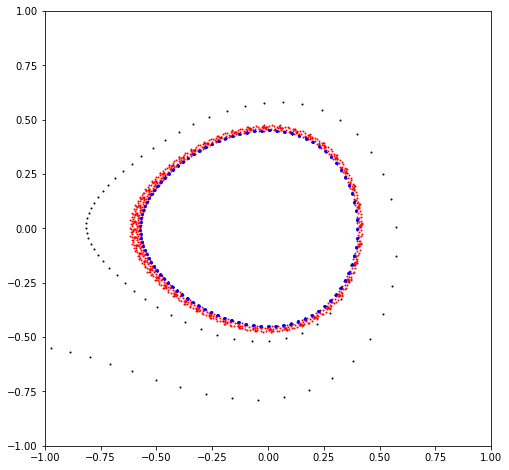

In [4]:
# Integrate for a given time step and ititial condition
# Note, hamiltonian is not preserved for all cases, but the hamiltonian drift time scale is different

# Set nonlinear oscillator hamiltonian function

def h(x):
    q, p = x
    return p**2/2 + q**2/2 + q**3/3

# Set time step

dt = torch.tensor(0.15, dtype=dtype, device=device)

# Set initial condition

xi = torch.tensor([0.4, 0.0], dtype=dtype, device=device)

# Integrate and plot orbits for several values of truncation order

count = 1024

plt.figure(figsize=(8, 8))
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)

for order, color in zip([1, 2, 4], ['black', 'red', 'blue']):
    orbit = []
    x = torch.clone(xi)
    for _ in range(count):
        x = taylor(order, dt, h, x)
        orbit.append(x)
    orbit = torch.stack(orbit)
    plt.scatter(*orbit.T.cpu().numpy(), color=color, s=1)
    
plt.show()

In [5]:
# Generate derivative table representation at zero
# Note, here a smaller time step is used

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
t = derivative(4, lambda x: taylor(6, 0.05, h, x), x)

# Compute series representation

s = series((2, ), (4, ), t)

# Print series

for key, value in s.items():
    print(f'{key}: {value.cpu()}')

(0, 0): tensor([0., 0.])
(1, 0): tensor([9.987502e-01, -4.997917e-02])
(0, 1): tensor([4.997917e-02, 9.987502e-01])
(2, 0): tensor([-1.249219e-03, -4.993753e-02])
(1, 1): tensor([-4.164063e-05, -2.497397e-03])
(0, 2): tensor([-5.206163e-07, -4.164063e-05])
(3, 0): tensor([5.203993e-07, 4.161458e-05])
(2, 1): tensor([2.604167e-08, 2.601563e-06])
(1, 2): tensor([4.340278e-10, 5.208334e-08])
(0, 3): tensor([0.000000e+00, 4.340278e-10])
(4, 0): tensor([-2.170139e-10, -2.604167e-08])
(3, 1): tensor([ 0.000000e+00, -1.736111e-09])
(2, 2): tensor([0., 0.])
(1, 3): tensor([0., 0.])
(0, 4): tensor([0., 0.])


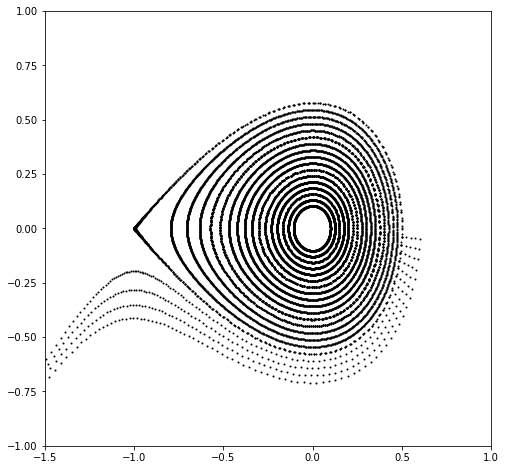

In [6]:
# Integrate using derivative table and a batch of initials

q = torch.linspace(0.1, 0.6, 21)
p = torch.zeros_like(q)
x = torch.stack([q, p]).T

orbits = []

for _ in range(count):
    x = torch.func.vmap(lambda x: evaluate(t, [x]))(x)
    orbits.append(x)

orbits = torch.stack(orbits).swapaxes(0, 1)

plt.figure(figsize=(8, 8))
plt.xlim(-1.5, 1)
plt.ylim(-1, 1)

for orbit in orbits:
    plt.scatter(*orbit.T.cpu().numpy(), color='black', s=1)
    
plt.show()

In [7]:
# Derivatives with respect to time step and other parameters

def h(x, kq, ks):
    q, p = x
    return p**2/2 + kq**2/2 + ks*q**3/3

dt = torch.tensor(0.01, dtype=dtype, device=device)
xi = torch.tensor([0.4, 0.0], dtype=dtype, device=device)
kq = torch.tensor(1.0, dtype=dtype, device=device)
ks = torch.tensor(1.0, dtype=dtype, device=device)

t = derivative((2, 1, 1, 1), lambda xi, dt, kq, ks: taylor(4, dt, h, xi, kq, ks), xi, dt, kq, ks)

In [8]:
# Check table

dxi = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
ddt = torch.tensor(0.005, dtype=dtype, device=device)
dkq = torch.tensor(0.01, dtype=dtype, device=device)
dks = torch.tensor(0.01, dtype=dtype, device=device)

print(taylor(4, dt + ddt, h, xi + dxi, kq + dkq, ks + dks))
print(evaluate(t, [dxi, ddt, dkq, dks]))

tensor([4.999716e-01, -3.787356e-03])
tensor([4.999748e-01, -3.787395e-03])


# Example-22: Yoshida integrator

In [1]:
# Given a time-reversible integration step of difference order 2n
# Yoshida coefficients can be used to construct integration step of difference order 2(n+1)
# s(2(n+1))(dt) = s(2n)(x1 dt) o s(2n)(x2 dt) o s(2n)(x1 dt)

# If a hamiltonian vector field can be splitted into several sovable parts
# Second order time-reversible symmetric integrator can be easily constructed
# s1(dt/2) o s2(dt/2) o ... o sn(dt/2) o sn(dt/2) o ... o s2(dt/2) o s1(dt/2)
# Yoshida procedure can be then applied repeatedly to obtain higher order integration steps

In [2]:
# Import

import numpy
import torch

from ndtorch.util import first
from ndtorch.util import nest
from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.yoshida import coefficients
from ndtorch.yoshida import yoshida

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Given integration step on Yoshida order n
# Yoshida coefficent for the next order can be computed

# Note, sum of coefficients is equal to one

print(coefficients(1)) # 2 -> 4
print(coefficients(2)) # 4 -> 6
print(coefficients(3)) # 6 -> 8
print(coefficients(4)) # 8 -> 10

[1.3512071919596578, -1.7024143839193153, 1.3512071919596578]
[1.1746717580893635, -1.349343516178727, 1.1746717580893635]
[1.1161829393253857, -1.2323658786507714, 1.1161829393253857]
[1.0870271062991708, -1.1740542125983413, 1.0870271062991708]


In [4]:
# Given integration step on Yoshida order n
# Yoshida coefficent for m order can be computed

# Note, sum of coefficients is equal to one

print([f'{coefficient:.3f}' for coefficient in coefficients(1, 1)]) # 2 -> 4
print([f'{coefficient:.3f}' for coefficient in coefficients(1, 2)]) # 2 -> 6
print([f'{coefficient:.3f}' for coefficient in coefficients(2, 2)]) # 4 -> 6

['1.351', '-1.702', '1.351']
['1.587', '-2.000', '1.587', '-1.823', '2.297', '-1.823', '1.587', '-2.000', '1.587']
['1.175', '-1.349', '1.175']


In [5]:
# Given a set of mappings and (start, final) Yoshida orders
# Corresponding Yoshida coefficients can be computed
# Note, mapping can be an integation step

# Mapping is a step (last argument should be False)

ns, cs = coefficients(1, 1, 1, False) ; print([ns, [f'{c:.3f}' for c in cs]]) # 2 -> 4
ns, cs = coefficients(1, 1, 2, False) ; print([ns, [f'{c:.3f}' for c in cs]]) # 2 -> 6
ns, cs = coefficients(1, 2, 2, False) ; print([ns, [f'{c:.3f}' for c in cs]]) # 4 -> 6
print()

# Two mappings (merge edge mappings)
# Note, number of mappings can be arbitrary

ns, cs = coefficients(2, 0, 0, True)  ; print([ns, [f'{c:.3f}' for c in cs]]) # 2 -> 2
ns, cs = coefficients(2, 0, 1, True)  ; print([ns, [f'{c:.3f}' for c in cs]]) # 2 -> 4
print()

[[0, 0, 0], ['1.351', '-1.702', '1.351']]
[[0, 0, 0, 0, 0, 0, 0, 0, 0], ['1.587', '-2.000', '1.587', '-1.823', '2.297', '-1.823', '1.587', '-2.000', '1.587']]
[[0, 0, 0], ['1.175', '-1.349', '1.175']]

[[0, 1, 0], ['0.500', '1.000', '0.500']]
[[0, 1, 0, 1, 0, 1, 0], ['0.676', '1.351', '-0.176', '-1.702', '-0.176', '1.351', '0.676']]



In [6]:
# Integrate rotation

# h = h1 + h2 
# h1 = 1/2 q**2 -> [q, p] -> [q, p - t*q]
# h2 = 1/2 p**2 -> [q, p] -> [q + t*q, p]

# Set mappings

def fn(x, t):
    q, p = x
    return torch.stack([q, p - t*q])

def gn(x, t):
    q, p = x
    return torch.stack([q + t*p, p])

# Set time step

t = torch.tensor(0.5, dtype=torch.float64)

# Set initial condition

x = torch.tensor([0.1, 0.1], dtype=torch.float64)

# Without merging

for i in range(10):
    print(yoshida(0, i, False, [fn, gn])(x, t), len(first(yoshida(0, i, False, [fn, gn]).table)))
print()

# With merging
    
for i in range(10):
    print(yoshida(0, i, True, [fn, gn])(x, t), len(first(yoshida(0, i, True, [fn, gn]).table)))
print()

tensor([1.375000e-01, 4.062500e-02], dtype=torch.float64) 3
tensor([1.354787e-01, 3.997254e-02], dtype=torch.float64) 9
tensor([1.357446e-01, 3.982467e-02], dtype=torch.float64) 27
tensor([1.357004e-01, 3.981894e-02], dtype=torch.float64) 81
tensor([1.356984e-01, 3.981700e-02], dtype=torch.float64) 243
tensor([1.357016e-01, 3.981564e-02], dtype=torch.float64) 729
tensor([1.357009e-01, 3.981567e-02], dtype=torch.float64) 2187
tensor([1.357007e-01, 3.981572e-02], dtype=torch.float64) 6561
tensor([1.357009e-01, 3.981567e-02], dtype=torch.float64) 19683
tensor([1.357007e-01, 3.981573e-02], dtype=torch.float64) 59049

tensor([1.375000e-01, 4.062500e-02], dtype=torch.float64) 3
tensor([1.354787e-01, 3.997254e-02], dtype=torch.float64) 7
tensor([1.357446e-01, 3.982467e-02], dtype=torch.float64) 19
tensor([1.357004e-01, 3.981894e-02], dtype=torch.float64) 55
tensor([1.356984e-01, 3.981700e-02], dtype=torch.float64) 163
tensor([1.357016e-01, 3.981564e-02], dtype=torch.float64) 487
tensor([1.357

In [7]:
# Several steps

count = 100
t = torch.tensor(0.5, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)
for _ in range(count):
    x = yoshida(0, 1, True, [fn, gn])(x, t/count)
print(x)

count = 100
t = torch.tensor(0.5, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)
x = nest(count, yoshida(0, 1, True, [fn, gn]))(x,  t/count)
print(x)

tensor([1.357008e-01, 3.981570e-02], dtype=torch.float64)
tensor([1.357008e-01, 3.981570e-02], dtype=torch.float64)


In [8]:
# Multistep

# h = h1 + h2 
# h1 = 1/2 q**2 + 1/3 q**3 -> [q, p] -> [q, p - t*q - t*q**2]
# h2 = 1/2 p**2            -> [q, p] -> [q + t*q, p]

def fn(x, t):
    q, p = x
    return torch.stack([q, p - t*q - t*q**2])

def gn(x, t):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor(0.1, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)

print(yoshida(0, 1, True, [fn, gn])(x, t))
print()

# h = h1 + h2 + h3
# h1 = 1/2 q**2 -> [q, p] -> [q, p - t*q]
# h2 = 1/3 q**3 -> [q, p] -> [q, p - t*q**2]
# h3 = 1/2 p**2 -> [q, p] -> [q + t*q, p]

def fn(x, t):
    q, p = x
    return torch.stack([q, p - t*q])

def gn(x, t):
    q, p = x
    return torch.stack([q, p - t*q**2])

def hn(x, t):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor(0.1, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)

print(yoshida(0, 1, True, [fn, gn, hn])(x, t))
print()

# Note, the last mapping has the smallest number of evaluations

sequence, _ = yoshida(0, 1, True, [fn, gn, hn]).table

print([*map(sequence.count, sorted(set(sequence)))])
print()

tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64)

tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64)

[4, 6, 3]



In [9]:
# Increase order

def fn(x, t):
    q, p = x
    return torch.stack([q, p - t*q - t*q**2])

def gn(x, t):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor(0.1, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)

s2 = yoshida(0, 0, True, [fn, gn])
print(torch.allclose(s2(x, t), yoshida(0, 0, True, [fn, gn])(x, t)))

s4 = yoshida(1, 1, False, [s2])
print(torch.allclose(s4(x, t), yoshida(0, 1, True, [fn, gn])(x, t)))

s6 = yoshida(1, 2, False, [s2])
print(torch.allclose(s6(x, t), yoshida(0, 2, True, [fn, gn])(x, t)))

s6 = yoshida(2, 2, False, [s4])
print(torch.allclose(s6(x, t), yoshida(0, 2, True, [fn, gn])(x, t)))

True
True
True
True


In [10]:
# Step with parameters (matched signatures)

def fn(x, t, a, b):
    q, p = x
    return torch.stack([q, p - a*t*q - b*t*q**2])

def gn(x, t, a, b):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor(0.1, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)
a = torch.tensor(1.0, dtype=torch.float64)
b = torch.tensor(1.0, dtype=torch.float64)

print(yoshida(0, 1, True, [fn, gn])(x, t, a, b))

tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64)


In [11]:
# Step with parameters (pass fixed parameters)

def fn(x, t, a, b):
    q, p = x
    return torch.stack([q, p - a*t*q - b*t*q**2])

def gn(x, t):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor(0.1, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)
a = torch.tensor(1.0, dtype=torch.float64)
b = torch.tensor(1.0, dtype=torch.float64)

print(yoshida(0, 1, True, [fn, gn], parameters=[[a, b], []])(x, t))

tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64)


In [12]:
# Step can be differentiated with respect to initials, time step and/or parametes

def fn(x, t, a, b):
    q, p = x
    return torch.stack([q, p - a*t*q - b*t*q**2])

def gn(x, t, a, b):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor(0.1, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)
a = torch.tensor(1.0, dtype=torch.float64)
b = torch.tensor(1.0, dtype=torch.float64)

# Derivative with respect to initial

print(derivative(1, yoshida(0, 1, True, [fn, gn]), x, t, a, b))
print()

# Derivative with respect to time step

print(derivative(1, lambda t, x, a, b: yoshida(0, 1, True, [fn, gn])(x, t, a, b), t, x, a, b))
print(derivative((0, 1), yoshida(0, 1, True, [fn, gn]), x, t, a, b))
print()

[tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64), tensor([[9.939735e-01, 9.979712e-02],
        [-1.207179e-01, 9.939427e-01]], dtype=torch.float64)]

[tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64), tensor([8.841321e-02, -1.214017e-01], dtype=torch.float64)]
[[tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64), tensor([8.841321e-02, -1.214017e-01], dtype=torch.float64)]]



In [13]:
# For derivative table propagation all knobs should be vectors

def fn(x, t, a, b):
    q, p = x
    return torch.stack([q, p - a*t*q - b*t*q**2])

def gn(x, t, a, b):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor([0.1], dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)
a = torch.tensor([1.0], dtype=torch.float64)
b = torch.tensor([1.0], dtype=torch.float64)

step = yoshida(0, 1, True, [fn, gn])

def wrapper(x, t, a, b):
    (t, ), (a, ), (b, ) = t, a, b
    return step(x, t, a, b)

print(step(x, *t, *a, *b))
print(wrapper(x, t, a, b))
print()

out = propagate((2, 1, 1, 1),
                4*(1, ),
                identity(4*(1, ), [x, t, a, b]),
                [t, a, b],
                wrapper)

dt = torch.tensor([+0.001], dtype=torch.float64)
dx = torch.tensor([+0.005, -0.005], dtype=torch.float64)
da = torch.tensor([-0.001], dtype=torch.float64)
db = torch.tensor([+0.001], dtype=torch.float64)

print(wrapper(x + dx, t + dt, a + da, b + db))
print(evaluate(out, [dx, dt, da, db]))

tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64)
tensor([1.094304e-01, 8.841961e-02], dtype=torch.float64)

tensor([1.139844e-01, 8.272697e-02], dtype=torch.float64)
tensor([1.139846e-01, 8.272929e-02], dtype=torch.float64)


In [14]:
# Given a step, its derivatives can be used as a taylor model
# Note, taylor model is not symplectic in general

torch.set_printoptions(precision=12, sci_mode=True, linewidth=128)

def fn(x, t, a, b):
    q, p = x
    return torch.stack([q, p - a*t*q - b*t*q**2])

def gn(x, t, a, b):
    q, p = x
    return torch.stack([q + t*p, p])

t = torch.tensor(0.1, dtype=torch.float64)
x = torch.tensor([0.1, 0.1], dtype=torch.float64)
a = torch.tensor(1.0, dtype=torch.float64)
b = torch.tensor(1.0, dtype=torch.float64)

dx = torch.tensor([+0.1, -0.1], dtype=torch.float64)

print(yoshida(0, 1, True, [fn, gn])(x, t, a, b))
print(yoshida(0, 1, True, [fn, gn])(x + dx, t, a, b))
print()

print(evaluate(derivative(1, yoshida(0, 1, True, [fn, gn]), x, t, a, b), [dx]))
print(evaluate(derivative(2, yoshida(0, 1, True, [fn, gn]), x, t, a, b), [dx]))
print(evaluate(derivative(3, yoshida(0, 1, True, [fn, gn]), x, t, a, b), [dx]))
print(evaluate(derivative(4, yoshida(0, 1, True, [fn, gn]), x, t, a, b), [dx]))
print(evaluate(derivative(5, yoshida(0, 1, True, [fn, gn]), x, t, a, b), [dx]))
print()

tensor([1.094303556041e-01, 8.841960703680e-02], dtype=torch.float64)
tensor([1.988014274981e-01, -2.394392236666e-02], dtype=torch.float64)

tensor([1.988479888736e-01, -2.304645602610e-02], dtype=torch.float64)
tensor([1.988014166220e-01, -2.394421962623e-02], dtype=torch.float64)
tensor([1.988014274804e-01, -2.394392240255e-02], dtype=torch.float64)
tensor([1.988014274981e-01, -2.394392236643e-02], dtype=torch.float64)
tensor([1.988014274981e-01, -2.394392236666e-02], dtype=torch.float64)



# Example-23: Direct invariant

In [1]:
# In this example Taylor invariants are constructed by solving I(f(x)) = I(x) order-by-order
# Mapping f(x) can be replaced with its derivative table representation of a given order n
# Or mapping can be used directly
# Invariant of order n+1 can be computed
# Note, to avoid trivial solution, initial invariant guess should be provided, e.g. linear part invariant

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.series import series
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.invariant import invariant

from twiss.twiss import twiss

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=10):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=5):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=20):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])


In [5]:
# Set transport maps between observation points

def map_01_02(x):
    x = quad(x, [0.0], 0.19, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21, 0.50)
    x = quad(x, [0.0], -0.21, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19, 0.50)
    return x

transport = [
    map_01_02
]

In [6]:
# Define one-turn transport

def fodo(x):
    for mapping in transport:
        x = mapping(x)
    return x

In [7]:
# Set evaluation point

# Note, zero is a fixed point and derivatives with respect to parameters are not used, i.e. no need to compute paraetric fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
fodo(x)

tensor([0., 0., 0., 0.], dtype=torch.float64)

In [8]:
# Generate derivative table representation for given order

t = identity(4, x, jacobian=torch.func.jacfwd)
t = propagate((4, ), (4, ), t, [], fodo, jacobian=torch.func.jacfwd)

In [9]:
# Compute linear normalization matrix

_, n, _ = twiss(derivative(1, lambda x: evaluate(t, [x]), x, intermediate=False))

In [10]:
# Set initial invariants

def ix(x):
    qx, px, qy, py = torch.linalg.inv(n) @ x
    return 1/2*(qx**2 + px**2)

def iy(x):
    qx, px, qy, py = torch.linalg.inv(n) @ x
    return 1/2*(qy**2 + py**2)

In [11]:
# Check conservation of linear invariants

print(derivative(2, ix, x, intermediate=False))
print(propagate((4, ), (2, ), t, [], ix, intermediate=False))
print()

print(derivative(2, iy, x, intermediate=False))
print(propagate((4, ), (2, ), t, [], iy, intermediate=False))
print()

tensor([[ 6.775970e-02, -1.148888e-15,  0.000000e+00,  0.000000e+00],
        [-1.148888e-15,  1.475804e+01,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00]], dtype=torch.float64)
tensor([[ 6.775970e-02, -1.151856e-15,  0.000000e+00,  0.000000e+00],
        [-1.151856e-15,  1.475804e+01,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00]], dtype=torch.float64)

tensor([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 8.242765e-02, 1.472561e-15],
        [0.000000e+00, 0.000000e+00, 1.472561e-15, 1.213185e+01]], dtype=torch.float64)
tensor([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.0000

In [12]:
# Compute nonlinear invariants
# Note, computation is not optimized and requires a lot of memory

tx, _ = invariant((4, ), x, [], ix, t, jacobian=torch.func.jacfwd, threshold=1.0E-3)
ty, _ = invariant((4, ), x, [], iy, t, jacobian=torch.func.jacfwd, threshold=1.0E-3)

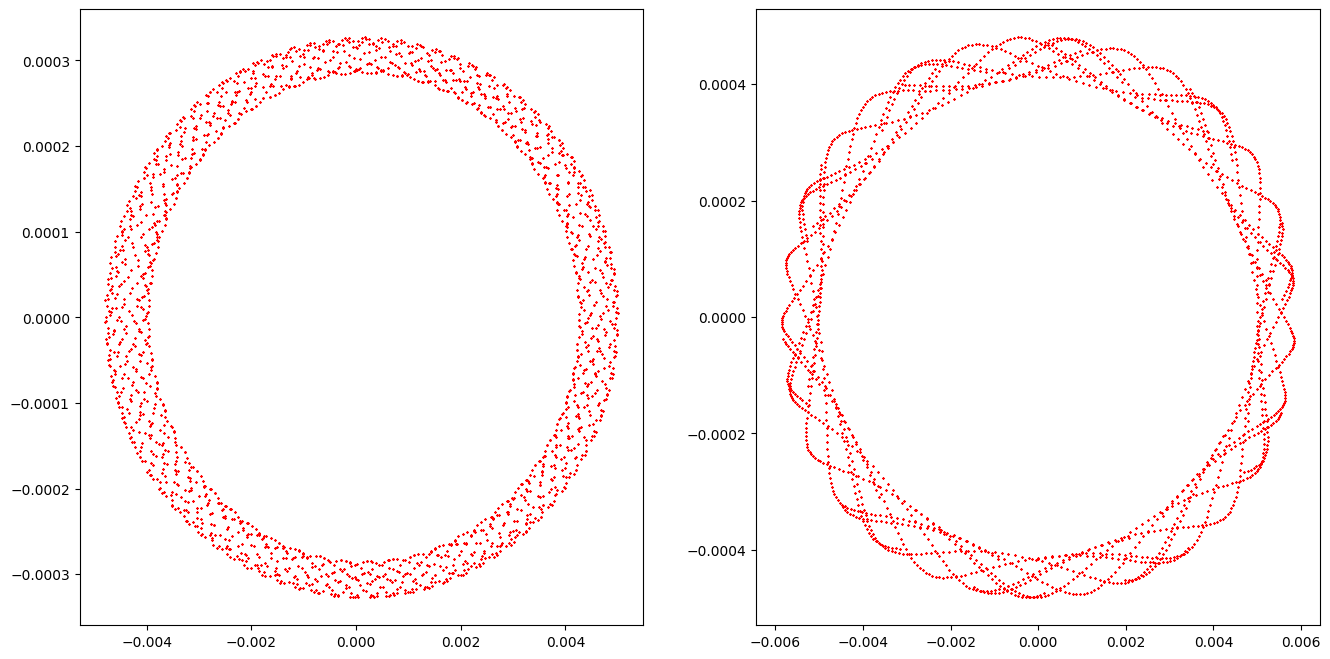

In [13]:
# Generate and plot trajectory

x = torch.tensor([0.005, 0.0, 0.005, 0.0], dtype=dtype, device=device)
bag = []
for _ in range(2048):
    x = fodo(x)
    bag.append(x)
bag = torch.stack(bag)
qx, px, qy, py = bag.T

plt.figure(figsize=(2*8, 8))
ax = plt.subplot(121)
ax.scatter(qx.cpu().numpy(), px.cpu().numpy(), marker='x', s=1, color='red')
ax = plt.subplot(122)
ax.scatter(qy.cpu().numpy(), py.cpu().numpy(), marker='x', s=1, color='red')
plt.show()

tensor(6.939136e-07, dtype=torch.float64)
tensor(8.133688e-08, dtype=torch.float64)

tensor(7.033768e-07, dtype=torch.float64)
tensor(2.919483e-09, dtype=torch.float64)

tensor(7.008737e-07, dtype=torch.float64)
tensor(1.419347e-09, dtype=torch.float64)



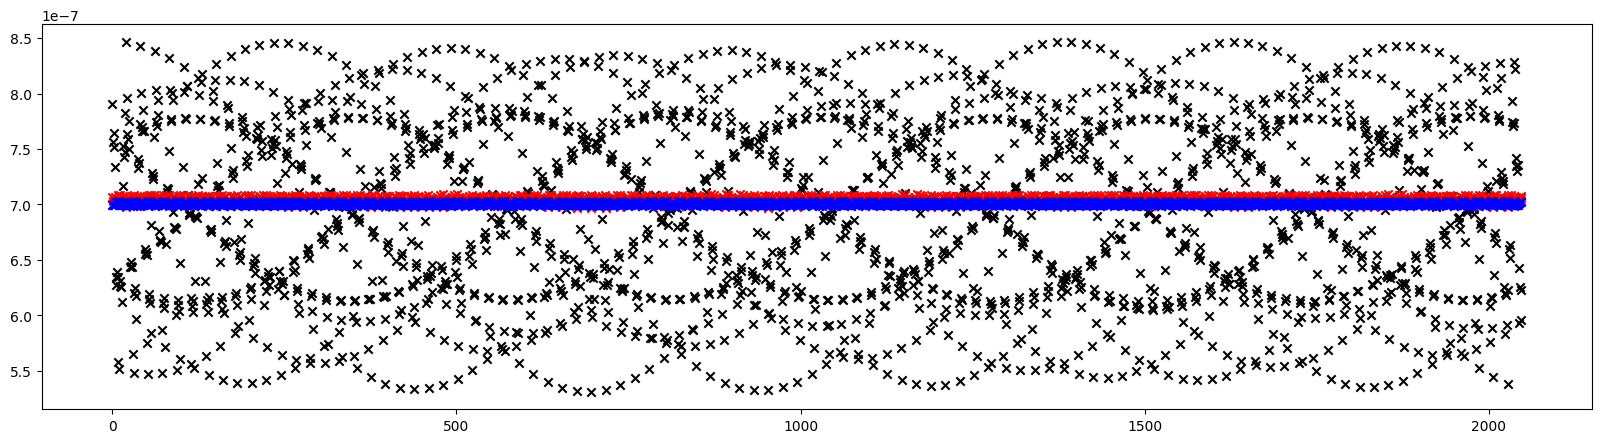

In [14]:
# 1st invariant conservation
# Note, for different initial conditions higher order invariants can give worse results

plt.figure(figsize=(20, 5))

for order, color in zip([2, 3, 4], ['black', 'red', 'blue']):
    sx = series((4, ), (order, ), tx)
    vx = torch.func.vmap(lambda x: evaluate(sx, [x]))(bag)
    print(vx.mean())
    print(vx.std())
    print()
    plt.scatter(range(len(vx)), vx.cpu().numpy(), color=color, marker='x')

plt.show()

tensor(1.222613e-06, dtype=torch.float64)
tensor(1.538842e-07, dtype=torch.float64)

tensor(1.200414e-06, dtype=torch.float64)
tensor(7.017794e-09, dtype=torch.float64)

tensor(1.206937e-06, dtype=torch.float64)
tensor(3.553736e-09, dtype=torch.float64)



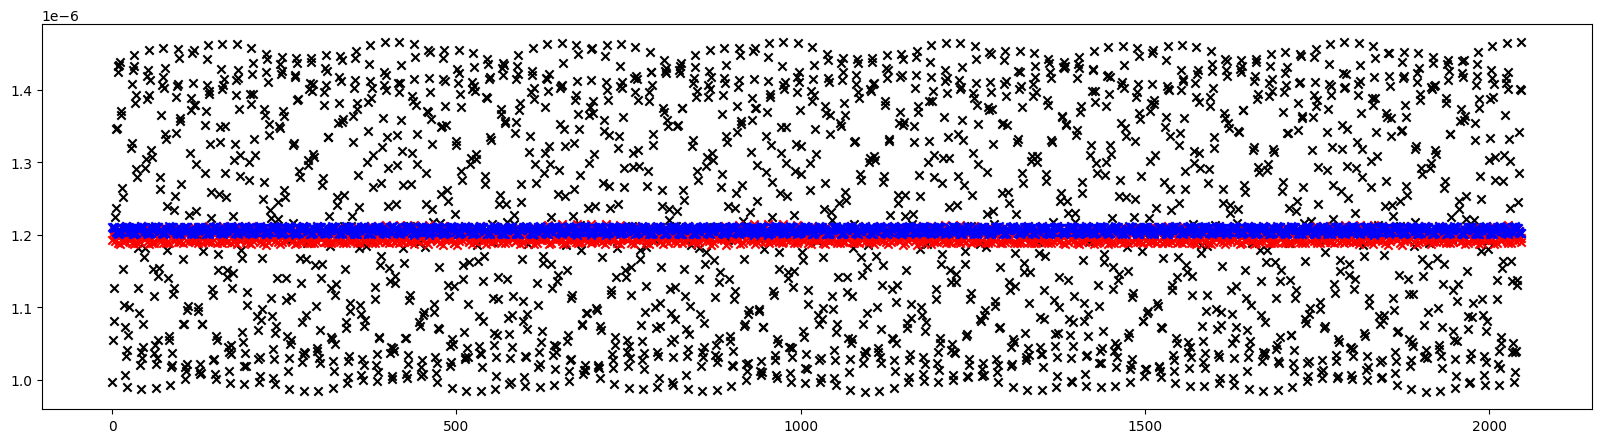

In [15]:
# 2nd invariant conservation
# Note, for different initial conditions higher order invariants can give worse results

plt.figure(figsize=(20, 5))

for order, color in zip([2, 3, 4], ['black', 'red', 'blue']):
    sy = series((4, ), (order, ), ty)
    vy = torch.func.vmap(lambda x: evaluate(sy, [x]))(bag)
    print(vy.mean())
    print(vy.std())
    print()
    plt.scatter(range(len(vy)), vy.cpu().numpy(), color=color, marker='x')

plt.show()

# Example-24: Direct invariant (parametric)

In [1]:
# Import

import numpy
import torch

from ndtorch.util import first
from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.series import split
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point
from ndtorch.invariant import invariant

from twiss.twiss import twiss

torch.set_printoptions(precision=6, sci_mode=True, linewidth=128)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=10):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=5):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=20):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])


In [4]:
# Set transport maps between observation points

def map_01_02(x, w, k):
    ksf, ksd, ksb = k
    x = quad(x, w, 0.19, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5 + ksf)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25 + ksb, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5 + ksd)
    x = drif(x, w, 0.45)
    x = quad(x, w, -0.21, 0.50)
    x = quad(x, w, -0.21, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5 + ksd)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25 + ksb, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5 + ksf)
    x = drif(x, w, 0.45)
    x = quad(x, w, 0.19, 0.50)
    return x

transport = [
    map_01_02
]

In [5]:
# Define one-turn transport

def fodo(x, k, w):
    for mapping in transport:
        x = mapping(x, k, w)
    return x

In [6]:
# Find fixed point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
w = torch.tensor(1*[0.0], dtype=dtype, device=device)
k = torch.tensor(3*[0.0], dtype=dtype, device=device)

fp = fixed_point(32, fodo, x, w, k, power=1)

print(fp)
print(fodo(fp, w, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Set computation orders

(nx, nw, nk) = (3, 1, 1)

In [8]:
# Find parametric fixed point

pfp = parametric_fixed_point((nw, nk), fp, [w, k], fodo)

In [9]:
# Test parametric fixed point
# Note, if fp is not zero, redefine one-turn transport to map zero to zero

print(compare(pfp, propagate((4, 1, 3), (0, nw, nk), pfp, [w, k], fodo)))

True


In [10]:
# Define a fodo variant around parametric fixed point

def mapping(x, w, k):
    x = x + evaluate(first(pfp), [w, k])
    x = fodo(x, w, k)
    x = x - evaluate(first(pfp), [w, k])
    return x

print(mapping(x, w, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [11]:
# Compute derivative table representation

# Note, no parametric part should be passed, parametric zero is transformed to parametric zero

t = identity((nx, nw, nk), x)
t = propagate((4, 1, 3), (nx - 1, nw, nk), t, [w, k], mapping)
chop(t)
print(first(t))

[[tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)], [tensor([[0.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64), tensor([[[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]], dtype=torch.float64)]]


In [12]:
# Compute parametric normalization matrix

def fn(w, k):
    m = derivative(1, lambda x: evaluate(t, [x, w, k]), fp, intermediate=False)
    _, n, _ = twiss(m)
    return n

tn = derivative((nw, nk), fn, w, k)

In [13]:
# Set initial invariants

def ix(x, w, k):
    qx, px, qy, py = torch.inverse(evaluate(tn, [w, k])) @ x
    return 1/2*(qx**2 + px**2)

def iy(x, w, k):
    qx, px, qy, py = torch.inverse(evaluate(tn, [w, k])) @ x
    return 1/2*(qy**2 + py**2)

In [14]:
# 1st invariant

tx, _ = invariant((nx, nw, nk), x, [w, k], ix, t, jacobian=torch.func.jacrev, threshold=0.01)
_

[]

In [15]:
# 2nd invariant

ty, _ = invariant((nx, nw, nk), x, [w, k], iy, t, jacobian=torch.func.jacrev, threshold=0.01)
_

[]

In [16]:
# Test conservation

# Note, here propagate is used as composition

print(compare(propagate((4, 1, 3), (nx-1, nw, nk), t, [w, k], tx), tx))
print(compare(propagate((4, 1, 3), (nx-1, nw, nk), t, [w, k], ty), ty))

True
True


In [17]:
# Series representation
# Note, generalized monomial is qx px qy py w ksf ksd ksb

s, *_ = split(clean(series((4, 1, 3), (nx, nw, nk), tx)))
s

{(2, 0, 0, 0, 0, 0, 0, 0): tensor(3.387985e-02, dtype=torch.float64),
 (0, 2, 0, 0, 0, 0, 0, 0): tensor(7.379018e+00, dtype=torch.float64),
 (2, 0, 0, 0, 0, 1, 0, 0): tensor(-6.047879e-03, dtype=torch.float64),
 (2, 0, 0, 0, 0, 0, 1, 0): tensor(-6.517039e-03, dtype=torch.float64),
 (0, 2, 0, 0, 0, 1, 0, 0): tensor(1.317226e+00, dtype=torch.float64),
 (0, 2, 0, 0, 0, 0, 1, 0): tensor(1.419409e+00, dtype=torch.float64),
 (2, 0, 0, 0, 1, 0, 0, 0): tensor(1.994743e-01, dtype=torch.float64),
 (0, 2, 0, 0, 1, 0, 0, 0): tensor(-4.344542e+01, dtype=torch.float64),
 (2, 0, 0, 0, 1, 1, 0, 0): tensor(-6.188913e-02, dtype=torch.float64),
 (2, 0, 0, 0, 1, 0, 1, 0): tensor(-8.813844e-02, dtype=torch.float64),
 (2, 0, 0, 0, 1, 0, 0, 1): tensor(6.534032e-01, dtype=torch.float64),
 (0, 2, 0, 0, 1, 1, 0, 0): tensor(-2.031422e+00, dtype=torch.float64),
 (0, 2, 0, 0, 1, 0, 1, 0): tensor(2.482422e+00, dtype=torch.float64),
 (0, 2, 0, 0, 1, 0, 0, 1): tensor(-1.423110e+02, dtype=torch.float64),
 (3, 0, 0, 0,

# Example-25: Composition

In [1]:
# In this example the following homomorphism is illustrated
# t(f o g) = t(f) o t(g)
# Meaning, table of composition is equal to composition of tables
# Mappings f and g that map zero to zero, i.e. are without constant part

In [2]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=10):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=5):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=20):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [5]:
# Set transport maps between observation points

def map_01_02(x):
    x = quad(x, [0.0], 0.19, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21, 0.50)
    return x

def map_02_03(x):
    x = quad(x, [0.0], -0.21, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19, 0.50)
    return x

In [6]:
# Set computation order & evaluation point

n = 4
x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

In [7]:
# Note, both mapping map zero to zero 
# Also, parameters that effect closed orbit are not used

print(map_01_02(x))
print(map_02_03(x))

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)


In [8]:
# Direct table generation

T = derivative(n, lambda x: map_02_03(map_01_02(x)), x)

In [9]:
# Propagation of identity (equvalent to direct table generation)

t = identity((n, ), [x])
t = propagate((4, ), (n, ), t, [], lambda x: map_02_03(map_01_02(x)))

print(compare(T, t))

True


In [10]:
# Propagation (split)

# Table is propagated through mappings
# Note, this evaluation is inherently sequential

t = identity((n, ), [x])
t = propagate((4, ), (n, ), t, [], map_01_02)
t = propagate((4, ), (n, ), t, [], map_02_03)

print(compare(T, t))

True


In [11]:
# Composition

# Note, given an evaluation point (e.g. closed orbit at each element)
# Identity can be propagated (or just perform direct computation) for each element
# This can significantly reduce computation cost

# Note, evaluations of t_01_02 and t_02_03 are independent and can be performed in parallel
# Also, propagation of table through table might be computationally less expensive

t_01_02 = identity((n, ), [x])
t_01_02 = propagate((4, ), (n, ), t_01_02, [], map_01_02)

t_02_03 = identity((n, ), [x])
t_02_03 = propagate((4, ), (n, ), t_02_03, [], map_02_03)

t = propagate((4, ), (n, ), t_01_02, [], t_02_03)

print(compare(T, t))

True


# Example-26: Composition (closed orbit)

In [1]:
# Composition illustration with non-zero closed orbit

In [2]:
# Import

import numpy
import torch

from ndtorch.util import first
from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point

from matplotlib import pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=10):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=5):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=20):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [5]:
# Set transport maps between observation points

# Note, kick is used to generate non-zero (dynamical) closed orbit
# Momentum deviation is used as a parameter (coupled to closed orbit via dispersion)

def map_01_02(x, w):
    x = kick(x, +1.0E-4, -1.0E-4)
    x = quad(x, w, 0.19, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5)
    x = drif(x, w, 0.45)
    x = quad(x, w, -0.21, 0.50)
    return x

def map_02_03(x, w):
    x = quad(x, w, -0.21, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5)
    x = drif(x, w, 0.45)
    x = quad(x, w, 0.19, 0.50)
    return x

In [6]:
# Set evaluation point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
w = torch.tensor(1*[0.0], dtype=dtype, device=device)

In [7]:
# Find (dynamical) fixed point

fp = fixed_point(32, lambda x, w: map_02_03(map_01_02(x, w), w), x, w, power=1)

# Check fixed point

print(fp)
print(map_02_03(map_01_02(fp, w), w))

tensor([ 8.418072943377e-04, -5.000000000000e-05, -2.043309959087e-03,
         5.000000000000e-05], dtype=torch.float64)
tensor([ 8.418072943377e-04, -5.000000000000e-05, -2.043309959087e-03,
         5.000000000000e-05], dtype=torch.float64)


In [8]:
# Set computation orders for state and each knob group

(nx, nw) = (4, 2)

In [9]:
# Find parametric fixed point

pfp = parametric_fixed_point((nw, ), fp, [w], lambda x, w: map_02_03(map_01_02(x, w), w))

# Check

print(compare(pfp, propagate((4, 1), (0, nw), pfp, [w], lambda x, w: map_02_03(map_01_02(x, w), w))))

True


In [10]:
# Set parametric fixed points at each map entrance

pfp_01 = identity((0, nw), [x, w], parametric=pfp)
pfp_02 = propagate((4, 1), (0, nw), pfp_01, [w], map_01_02)

# Check

print(compare(pfp_01, propagate((4, 1), (0, nw), pfp_01, [w], lambda x, w: map_02_03(map_01_02(x, w), w))))
print(compare(pfp_02, propagate((4, 1), (0, nw), pfp_02, [w], lambda x, w: map_01_02(map_02_03(x, w), w))))

True
True


In [11]:
# Define transformations around parametric fixed points

# Note, this transformation map zero (parametric) state to zero (upto given order)
# This is true by construction

def fn_01_02(x, w):
    return map_01_02(x + evaluate(first(pfp_01), [w]), w) - evaluate(first(pfp_02), [w])

def fn_02_03(x, w):
    return map_02_03(x + evaluate(first(pfp_02), [w]), w) - evaluate(first(pfp_01), [w])

print(propagate((4, 1), (0, nw), identity((0, nw), [x, w]), [w], fn_01_02))

[[tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([[0.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64), tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]]], dtype=torch.float64)]]


In [12]:
# Propagate identity sequentially

T = identity((nx, nw), [x, w], parametric=pfp)
T = propagate((4, 1), (nx, nw), T, [w], lambda x, w: map_01_02(x, w))
T = propagate((4, 1), (nx, nw), T, [w], lambda x, w: map_02_03(x, w))

In [13]:
# Composition

# Note, parametric part is zero, other elements of t should be equal to corresponding elements of T

t_01_02 = identity((nx, nw), [x, w])
t_01_02 = propagate((4, 1), (nx, nw), t_01_02, [w], fn_01_02)

t_02_03 = identity((nx, nw), [x, w])
t_02_03 = propagate((4, 1), (nx, nw), t_02_03, [w], fn_02_03)

t = propagate((4, 1), (nx, nw), t_01_02, [w], t_02_03)

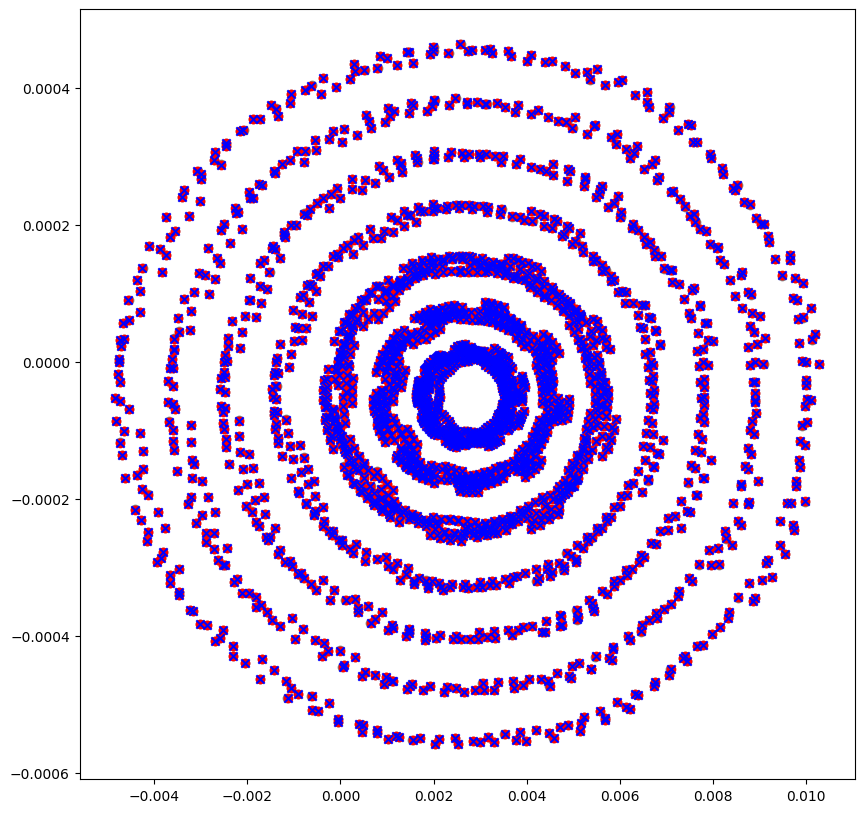

In [14]:
# Compare phase space trajectories

plt.figure(figsize=(10, 10))

qx = torch.linspace(0.0, 0.01, 10, dtype=dtype, device=device)
px = torch.zeros_like(qx) + 1.0E-12
qy = torch.zeros_like(qx) + 1.0E-03
py = torch.zeros_like(qx) + 1.0E-12

x = torch.stack([qx, px, qy, py]).T

w = torch.tensor([1.0E-3], dtype=dtype, device=device)

count = 256
table = []
y = torch.clone(x)
for _ in range(count):
    table.append(y)
    y = torch.func.vmap(lambda x: map_02_03(map_01_02(x, w), w))(y)
table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table
for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='gray', marker='o')
    

count = 256
table = []
y = torch.clone(x)
for _ in range(count):
    table.append(y)
    y = y - evaluate(first(pfp), [w])
    y = torch.func.vmap(lambda x: evaluate(T, [x, w]))(y)
table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table
for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='red', marker='o')
    

count = 256
table = []
y = torch.clone(x)
for _ in range(count):
    table.append(y)
    y = y - evaluate(first(pfp), [w])
    y = torch.func.vmap(lambda x: evaluate(t, [x, w]))(y)
    y = y + evaluate(first(pfp), [w])
table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table
for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='blue', marker='x')    
    
plt.show()

# Example-27: Inverse

In [1]:
# Import

import numpy
import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.inverse import inverse

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=10):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=5):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=20):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points

def map_01_02(x):
    x = quad(x, [0.0], 0.19, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21, 0.50)
    x = quad(x, [0.0], -0.21, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19, 0.50)
    return x

In [5]:
# Set computation order & evaluation point

n = 3
x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

print(map_01_02(x))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Compute derivative table

t = identity((n, ), [x])
t = propagate((4, ), (n, ), t, [], lambda x: map_01_02(x))

In [7]:
# Compute inverse

t_inv = inverse((n, ), x, [], t)

In [8]:
# Check

out = propagate((4, ), (n, ), t_inv, [], t)
chop(out, replace=True)
out

[[],
 tensor([[1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]],
        dtype=torch.float64),
 [],
 []]

# Example-28: Inverse (closed orbit)

In [1]:
# Import

import numpy
import torch

from ndtorch.util import first
from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point
from ndtorch.inverse import inverse

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=10):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=5):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=20):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set transport maps between observation points

def map_01_02(x, w):
    x = kick(x, +1.0E-4, -1.0E-4)
    x = quad(x, w, 0.19, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5)
    x = drif(x, w, 0.45)
    x = quad(x, w, -0.21, 0.50)
    x = quad(x, w, -0.21, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5)
    x = drif(x, w, 0.45)
    x = quad(x, w, 0.19, 0.50)
    return x

In [5]:
# Set evaluation point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
w = torch.tensor(1*[0.0], dtype=dtype, device=device)

In [6]:
# Find (dynamical) fixed point

fp = fixed_point(32, lambda x, w: map_01_02(x, w), x, w, power=1)

# Check fixed point

print(fp)
print(map_01_02(fp, w))

tensor([ 8.418072943377e-04, -5.000000000000e-05, -2.043309959087e-03,
         5.000000000000e-05], dtype=torch.float64)
tensor([ 8.418072943377e-04, -5.000000000000e-05, -2.043309959087e-03,
         5.000000000000e-05], dtype=torch.float64)


In [7]:
# Set computation orders for state and each knob group

(nx, nw) = (3, 2)

In [8]:
# Find parametric fixed point

pfp = parametric_fixed_point((nw, ), fp, [w], lambda x, w: map_01_02(x, w))

# Check

print(compare(pfp, propagate((4, 1), (0, nw), pfp, [w], lambda x, w: map_01_02(x, w))))

True


In [9]:
# Define transformations around parametric fixed points

# Note, this transformation map zero (parametric) state to zero (upto given order)
# This is true by construction

def fn_01_02(x, w):
    return map_01_02(x + evaluate(first(pfp), [w]), w) - evaluate(first(pfp), [w])

out = propagate((4, 1), (0, nw), identity((0, nw), [x, w]), [w], fn_01_02)
chop(out, replace=True)
out

[[[], [], []]]

In [10]:
# Compute derivative table

t = identity((nx, nw), [x, w])
t = propagate((4, 1), (nx, nw), t, [w], lambda x, w: fn_01_02(x, w))

In [11]:
# Compute inverse

t_inv = inverse((nx, nw), x, [w], t)

In [12]:
# Check

out = propagate((4, 1), (nx, nw), t_inv, [w], t)
chop(out, replace=True)
out

[[[], [], []],
 [tensor([[1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
          [0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
          [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],
          [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]],
         dtype=torch.float64),
  [],
  []],
 [[], [], []],
 [[], [], []]]

# Example-29: Momenta generator

In [1]:
# In this example initial and final monemta are computed from given initial and final coordinates
# Given an origing preserving mapping, its table representation can be computed upto some order
# This representation can be considered as exact
# Next, given initial and final coordinates, corresponding momenta can be computed using momenta generator

In [2]:
# Import

import numpy
import torch

from ndtorch.util import first
from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.pfp import fixed_point
from ndtorch.pfp import parametric_fixed_point
from ndtorch.momenta import momenta

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=10):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=5):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=20):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [5]:
# Set transport maps between observation points

def map_01_02(x, w):
    x = kick(x, +1.0E-4, -1.0E-4)
    x = quad(x, w, 0.19, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5)
    x = drif(x, w, 0.45)
    x = quad(x, w, -0.21, 0.50)
    x = quad(x, w, -0.21, 0.50)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, -0.5)
    x = drif(x, w, 0.45)
    x = bend(x, w, 22.92, 0.015, 0.25, 3.0)
    x = drif(x, w, 0.45)
    x = sext(x, w, 0.1, +0.5)
    x = drif(x, w, 0.45)
    x = quad(x, w, 0.19, 0.50)
    return x

In [6]:
# Set evaluation point

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
w = torch.tensor(1*[0.0], dtype=dtype, device=device)

In [7]:
# Find (dynamical) fixed point

fp = fixed_point(32, lambda x, w: map_01_02(x, w), x, w, power=1)

# Check fixed point

print(fp)
print(map_01_02(fp, w))

tensor([ 8.418072943377e-04, -5.000000000000e-05, -2.043309959087e-03,
         5.000000000000e-05], dtype=torch.float64)
tensor([ 8.418072943377e-04, -5.000000000000e-05, -2.043309959087e-03,
         5.000000000000e-05], dtype=torch.float64)


In [8]:
# Set computation orders for state and each knob group

(nx, nw) = (4, 2)

In [9]:
# Find parametric fixed point

pfp = parametric_fixed_point((nw, ), fp, [w], lambda x, w: map_01_02(x, w))

# Check

print(compare(pfp, propagate((4, 1), (0, nw), pfp, [w], lambda x, w: map_01_02(x, w))))

True


In [10]:
# Define transformations around parametric fixed points

# Note, this transformation map zero (parametric) state to zero (upto given order)
# This is true by construction

def fn_01_02(x, w):
    return map_01_02(x + evaluate(first(pfp), [w]), w) - evaluate(first(pfp), [w])

out = propagate((4, 1), (0, nw), identity((0, nw), [x, w]), [w], fn_01_02)
chop(out)
out

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[0.],
          [0.],
          [0.],
          [0.]], dtype=torch.float64),
  tensor([[[0.]],
  
          [[0.]],
  
          [[0.]],
  
          [[0.]]], dtype=torch.float64)]]

In [11]:
# Compute derivative table

t = identity((nx, nw), [x, w])
t = propagate((4, 1), (nx, nw), t, [w], lambda x, w: fn_01_02(x, w))

In [12]:
# Compute momenta generator

# Note, computation order can be different from that of the input table
# Accuracy is strongly related to computation order and magnitude of initial coordinates

m = momenta((nx, nw), x, [w], t)

In [13]:
# Recover momenta from coordinates

# Set deviations

xi = torch.tensor([0.0005, 0.0001, -0.0005, -0.0001], dtype=dtype, device=device)
dw = torch.tensor(1*[0.0001], dtype=dtype, device=device)

# Evaluate final state using table representation

xf = evaluate(t, [xi, dw])

print(xf)
print()

# Set initial and final coordinates

qi, _ = xi.reshape(-1, 2).T
qf, _ = xf.reshape(-1, 2).T
qs = torch.cat([qf, qi])

print(qs)
print()

# Set initial and final momenta

_, pi, = xi.reshape(-1, 2).T
_, pf, = xf.reshape(-1, 2).T
ps = torch.cat([pf, pi])

print(ps)
print()

# Evaluate generator using coordinates

print(evaluate(m, [qs, 0*dw]))
print(evaluate(m, [qs, 1*dw]))

tensor([ 1.536782226285e-03, -2.360460895977e-05, -1.128298475344e-03,
        -6.800430927953e-05], dtype=torch.float64)

tensor([1.536782226285e-03, -1.128298475344e-03, 5.000000000000e-04, -5.000000000000e-04],
       dtype=torch.float64)

tensor([-2.360460895977e-05, -6.800430927953e-05,  1.000000000000e-04,
        -1.000000000000e-04], dtype=torch.float64)

tensor([-2.353065307569e-05, -6.780339520304e-05,  9.993585406462e-05,
        -1.001716171999e-04], dtype=torch.float64)
tensor([-2.360460892419e-05, -6.800430928312e-05,  9.999999996933e-05,
        -1.000000000050e-04], dtype=torch.float64)


# Example-30: Factorization (kick)

In [1]:
# Given a derivative table representation (taylor series) of an origin preserving mapping
# It is possible to factorize it into composition of linear and nonlinear table representations
# If original mapping represents a single turn, linear part can be brought to its normal form
# This can be done using linear theory
# The nonlinear part is a near identity transformation, it can be represented with Lie transformation
# t = tl o tn and tn = exp(-[h])
# In this example (generator) h is computed for a single kick
# It can be used to construct nonlinear normal forms or as a redundancy free representation

In [2]:
# Import

import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.taylor import taylor
from ndtorch.inverse import inverse
from ndtorch.factorization import hamiltonian

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set transformation

# Note, this transformation can be exactly represented with a taylor series (i.e. polynomial)

def mapping(x, k, l):
    (qx, px, qy, py), (k, ), l = x, k, l/2
    qx, qy = qx + l*px, qy + l*py
    px, py = px - 1.0*l*k*(qx**2 - qy**2), py + 2.0*l*k*qx*qy
    qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py])

# Test origin propagation

x = torch.tensor(4*[0.0], dtype=dtype, device=device)
k = torch.tensor(1*[0.0], dtype=dtype, device=device)

print(mapping(x, k, 0.1))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Compute table representation

t = identity((2, 1), [x, k])
t = propagate((4, 1), (2, 1), t, [k], mapping, 0.1)

In [6]:
# Compare for some deviation

dx = torch.tensor([0.1, 0.01, 0.05, 0.01], dtype=dtype, device=device)
dk = torch.tensor([1.0],dtype=dtype, device=device)

print(mapping(x + dx, k + dk, 0.1))
print(evaluate(t, [dx, dk]))

tensor([1.009811250000e-01, 9.622500000000e-03, 5.102537625000e-02, 1.050752500000e-02],
       dtype=torch.float64)
tensor([1.009811250000e-01, 9.622500000000e-03, 5.102537625000e-02, 1.050752500000e-02],
       dtype=torch.float64)


In [7]:
# Linear part is not near identity

print(derivative(1, lambda x, k: evaluate(t, [x, k]), x, k, intermediate=False))

tensor([[1.000000000000e+00, 1.000000000000e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 1.000000000000e-01],
        [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]],
       dtype=torch.float64)


In [8]:
# Set linear part and compose with its inverse

l = derivative(1, lambda x, k: evaluate(t, [x, k]), x, k)
t = propagate((4, 1), (2, 1), inverse(1, x, [k], l), [k], t)
chop(t)

In [9]:
# Now table represents a near identity transformation

print(derivative(1, lambda x, k: evaluate(t, [x, k]), x, k, intermediate=False))

tensor([[1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]],
       dtype=torch.float64)


In [10]:
# Compute single exponent generator

h = hamiltonian((2, 1), x, [k], t)
chop(h)

# Compute series representation

# Note, each coefficient is proportional to strength

s = clean(series((4, 1), (3, 1), h))
for index, value in s.items():
    print(index, value.squeeze())

(3, 0, 0, 0, 1) tensor(1.666666666667e-02, dtype=torch.float64)
(2, 1, 0, 0, 1) tensor(-2.500000000000e-03, dtype=torch.float64)
(1, 2, 0, 0, 1) tensor(1.250000000000e-04, dtype=torch.float64)
(1, 0, 2, 0, 1) tensor(-5.000000000000e-02, dtype=torch.float64)
(1, 0, 1, 1, 1) tensor(5.000000000000e-03, dtype=torch.float64)
(1, 0, 0, 2, 1) tensor(-1.250000000000e-04, dtype=torch.float64)
(0, 3, 0, 0, 1) tensor(-2.083333333333e-06, dtype=torch.float64)
(0, 1, 2, 0, 1) tensor(2.500000000000e-03, dtype=torch.float64)
(0, 1, 1, 1, 1) tensor(-2.500000000000e-04, dtype=torch.float64)
(0, 1, 0, 2, 1) tensor(6.250000000000e-06, dtype=torch.float64)


In [11]:
# In this example, this hamiltonian generates exact solution with taylor intergator

print(mapping(x + dx, k + dk, 0.1))
print(taylor(1, 1.0, lambda x, k: evaluate(h, [x, k]), evaluate(l, [dx, dk]), dk))

tensor([1.009811250000e-01, 9.622500000000e-03, 5.102537625000e-02, 1.050752500000e-02],
       dtype=torch.float64)
tensor([1.009811250000e-01, 9.622500000000e-03, 5.102537625000e-02, 1.050752500000e-02],
       dtype=torch.float64)


# Example-31: Factorization (fodo)

In [1]:
# Import

import torch

from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.taylor import taylor
from ndtorch.inverse import inverse
from ndtorch.factorization import hamiltonian
from ndtorch.factorization import solution

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set elements

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=5):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def sext(x, w, ks, l, n=1):
    (qx, px, qy, py), (w, ), ks, l = x, w, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def bend(x, w, r, kq, ks, l, n=10):
    (qx, px, qy, py), (w, ), r, kq, ks, l = x, w, r, kq, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx - 1.0*l*ks*(qx**2 - qy**2) + 2.0*l/r**2*(w*r - qx), py + 2.0*l*kq*qy + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py]) 

def kick(x, cx, cy):
    (qx, px, qy, py) = x
    return torch.stack([qx, px + cx, qy, py + cy])    

def slip(x, dx, dy):
    (qx, px, qy, py) = x
    return torch.stack([qx + dx, px, qy + dy, py])

In [4]:
# Set fodo

def fodo(x):
    x = quad(x, [0.0], 0.19, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], -0.21, 0.50)
    x = quad(x, [0.0], -0.21, 0.50)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, -0.5)
    x = drif(x, [0.0], 0.45)
    x = bend(x, [0.0], 22.92, 0.015, 0.25, 3.0)
    x = drif(x, [0.0], 0.45)
    x = sext(x, [0.0], 0.1, +0.5)
    x = drif(x, [0.0], 0.45)
    x = quad(x, [0.0], 0.19, 0.50)
    return x

In [5]:
# Set computation order & evaluation point

n = 4
x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Note, origin is preserved

fodo(x)

tensor([0., 0., 0., 0.], dtype=torch.float64)

In [6]:
# Compute derivative table

t = identity((n, ), [x])
t = propagate((4, ), (n, ), t, [], lambda x: fodo(x))

In [7]:
# Set linear part

l = derivative(1, lambda x: evaluate(t, [x]), x)
l

[tensor([0., 0., 0., 0.], dtype=torch.float64),
 tensor([[8.259928915375e-02, 1.470387298165e+01, 0.000000000000e+00, 0.000000000000e+00],
         [-6.754528950779e-02, 8.259928915375e-02, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 8.239443265215e-01, 6.857644998910e+00],
         [0.000000000000e+00, 0.000000000000e+00, -4.682595072274e-02, 8.239443265215e-01]],
        dtype=torch.float64)]

In [8]:
# Set nonlinear part

u = propagate((4, ), (n, ), inverse(1, x, [], l), [], t)
chop(u)
derivative(1, lambda x: evaluate(u, [x]), x)

[tensor([0., 0., 0., 0.], dtype=torch.float64),
 tensor([[1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]],
        dtype=torch.float64)]

In [9]:
# Compute hamiltonian

h = hamiltonian((n, ), x, [], u)
chop(h)

In [10]:
# Compute series representation

s = clean(series((4, ), (n + 1, ), h), epsilon=1.0E-9)
for index, value in s.items():
    print(index, value.squeeze())

(3, 0, 0, 0) tensor(5.024988945080e-02, dtype=torch.float64)
(2, 1, 0, 0) tensor(-8.027849817894e-01, dtype=torch.float64)
(1, 2, 0, 0) tensor(1.242554019904e+01, dtype=torch.float64)
(1, 0, 2, 0) tensor(-5.976214487541e-01, dtype=torch.float64)
(1, 0, 1, 1) tensor(3.719621673904e+00, dtype=torch.float64)
(1, 0, 0, 2) tensor(-6.659517059512e+00, dtype=torch.float64)
(0, 3, 0, 0) tensor(-1.465736828313e+02, dtype=torch.float64)
(0, 1, 2, 0) tensor(7.616595688746e+00, dtype=torch.float64)
(0, 1, 1, 1) tensor(-6.812652464723e+01, dtype=torch.float64)
(0, 1, 0, 2) tensor(1.637189795764e+02, dtype=torch.float64)
(4, 0, 0, 0) tensor(-2.670453079972e-02, dtype=torch.float64)
(3, 1, 0, 0) tensor(1.592046859279e+00, dtype=torch.float64)
(2, 2, 0, 0) tensor(-4.015290100155e+01, dtype=torch.float64)
(2, 0, 2, 0) tensor(1.098921583040e-02, dtype=torch.float64)
(2, 0, 1, 1) tensor(-1.150214563563e+00, dtype=torch.float64)
(2, 0, 0, 2) tensor(5.596016324538e+00, dtype=torch.float64)
(1, 3, 0, 0) ten

In [11]:
# Restore mapping table nonlinear part from hamiltonian

print(compare(u, solution((n, ), x, [], h)))
print(compare(t, propagate((4, ), (n, ), l, [], solution((n, ), x, [], h))))

True
True


# Example-32: Factorization (factorize)

In [1]:
# Import

import torch
from ndtorch.derivative import derivative
from ndtorch.signature import chop
from ndtorch.evaluate import evaluate
from ndtorch.evaluate import compare
from ndtorch.series import series
from ndtorch.series import clean
from ndtorch.series import split
from ndtorch.propagate import identity
from ndtorch.propagate import propagate
from ndtorch.bracket import bracket
from ndtorch.factorization import hamiltonian
from ndtorch.factorization import solution
from ndtorch.factorization import factorize

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Set test hamiltonian function and compute corresponding table representation

# Note, test hamiltonian is near identity

def h(x, u, v):
    q, p = x
    u, = u
    v, = v
    h1 = (1 + u + u**2)*q**3 + q**2*p + q*p**2 + p**3
    h2 = (1 + v)*q**4 + q**3*p + q**2*p**2 + q*p**3 + p**4
    h3 = q**5 + q**4*p + q**3*p**2 + q**2*p**3 + q*p**4 + p**5
    return h1 + h2 + h3

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
u = torch.tensor([0.0], dtype=dtype, device=device)
v = torch.tensor([0.0], dtype=dtype, device=device)

h = derivative((5, 2, 1), h, x, u, v)
chop(h, replace=True)

s, *_ = split(clean(series((2, 1, 1), (5, 2, 1), h)))
s

{(3, 0, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (2, 1, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (1, 2, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (0, 3, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (3, 0, 1, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (3, 0, 2, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (4, 0, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (3, 1, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (2, 2, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (1, 3, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (0, 4, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (4, 0, 0, 1): tensor(1.000000000000e+00, dtype=torch.float64),
 (5, 0, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (4, 1, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (3, 2, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (2, 3, 0, 0): tensor(1.000000000000e+00

In [4]:
# Compute solution

t = solution((4, 2, 1), x, [u, v], h)

In [5]:
# Compute hamiltonian from solution and compare

compare(h, hamiltonian((4, 2, 1), x, [u, v], t))

True

In [6]:
# Perform factorization

h1, h2, h3, *_ = factorize((4, 2, 1), x, [u, v], t)

In [7]:
# Examine series representation

s, *_ = split(clean(series((2, 1, 1), (5, 1), h1)))
s

{(3, 0, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (2, 1, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (1, 2, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (0, 3, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (3, 0, 1, 0): tensor(1.000000000000e+00, dtype=torch.float64)}

In [8]:
# Examine series representation

s, *_ = split(clean(series((2, 1, 1), (5, 1), h2)))
s

{(4, 0, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (3, 1, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (2, 2, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (1, 3, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (0, 4, 0, 0): tensor(1.000000000000e+00, dtype=torch.float64),
 (4, 0, 0, 1): tensor(1.000000000000e+00, dtype=torch.float64)}

In [9]:
# Examine series representation

s, *_ = split(clean(series((2, 1, 1), (5, 1), h3)))
s

{(5, 0, 0, 0): tensor(5.000000000000e-01, dtype=torch.float64),
 (4, 1, 0, 0): tensor(-5.000000000000e-01, dtype=torch.float64),
 (3, 2, 0, 0): tensor(-2.000000000000e+00, dtype=torch.float64),
 (2, 3, 0, 0): tensor(4.000000000000e+00, dtype=torch.float64),
 (1, 4, 0, 0): tensor(2.500000000000e+00, dtype=torch.float64),
 (0, 5, 0, 0): tensor(1.500000000000e+00, dtype=torch.float64),
 (5, 0, 0, 1): tensor(-2.000000000000e+00, dtype=torch.float64),
 (4, 1, 0, 1): tensor(-4.000000000000e+00, dtype=torch.float64),
 (3, 2, 0, 1): tensor(-6.000000000000e+00, dtype=torch.float64),
 (5, 0, 1, 0): tensor(1.500000000000e+00, dtype=torch.float64),
 (4, 1, 1, 0): tensor(3.000000000000e+00, dtype=torch.float64),
 (3, 2, 1, 0): tensor(4.500000000000e+00, dtype=torch.float64),
 (2, 3, 1, 0): tensor(6.000000000000e+00, dtype=torch.float64)}

In [10]:
# Compute solutions

t1 = solution((4, 2, 1), x, [u, v], h1)
t2 = solution((4, 2, 1), x, [u, v], h2)
t3 = solution((4, 2, 1) ,x, [u, v], h3)

In [11]:
# Compose individual solutions and compare with initial solution

T = identity((4, 2, 1), [x, u, v])
T = propagate((2, 1, 1), (4, 2, 1), T, [u, v], t1)
T = propagate((2, 1, 1), (4, 2, 1), T, [u, v], t2)
T = propagate((2, 1, 1), (4, 2, 1), T, [u, v], t3)
compare(t, T)

True